In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import zipfile
import os

dataset_path = '/content/drive/MyDrive/archive.zip'

extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
data_path = '/content/data/powerconsumption.csv'
df = pd.read_csv(data_path)
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


Этап 1. Углублённая декомпозиция и анализ остатков


Задача: Разложить ряд из ЛР № 1 на компоненты и оценить качество декомпозиции.

📌 Что нужно сделать:
- Применить аддитивную и мультипликативную декомпозицию (seasonal_decompose).
- Подобрать оптимальный период сезонности (7, 30, 365 и др.).
- Проанализировать остатки:
  - Проверить стационарность (ADF, KPSS),
  - Построить ACF/PACF остатков,
  - Проверить нормальность (гистограмма, Q-Q plot).
  - Выбрать лучшую модель декомпозиции на основе анализа остатков.
  - Визуализировать все компоненты.


🛠️ Инструменты: statsmodels.tsa.seasonal.seasonal_decompose

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def additive_decomposition(series, period=24):
    """Аддитивная декомпозиция"""
    result = seasonal_decompose(series, model='additive', period=period)
    return result

def multiplicative_decomposition(series, period=24):
    """Мультипликативная декомпозиция"""
    result = seasonal_decompose(series, model='multiplicative', period=period)
    return result

def plot_decomposition(decomposition, title):
    """Визуализация результатов декомпозиции"""
    fig = decomposition.plot()
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(12, 8)
    plt.tight_layout()
    plt.show()

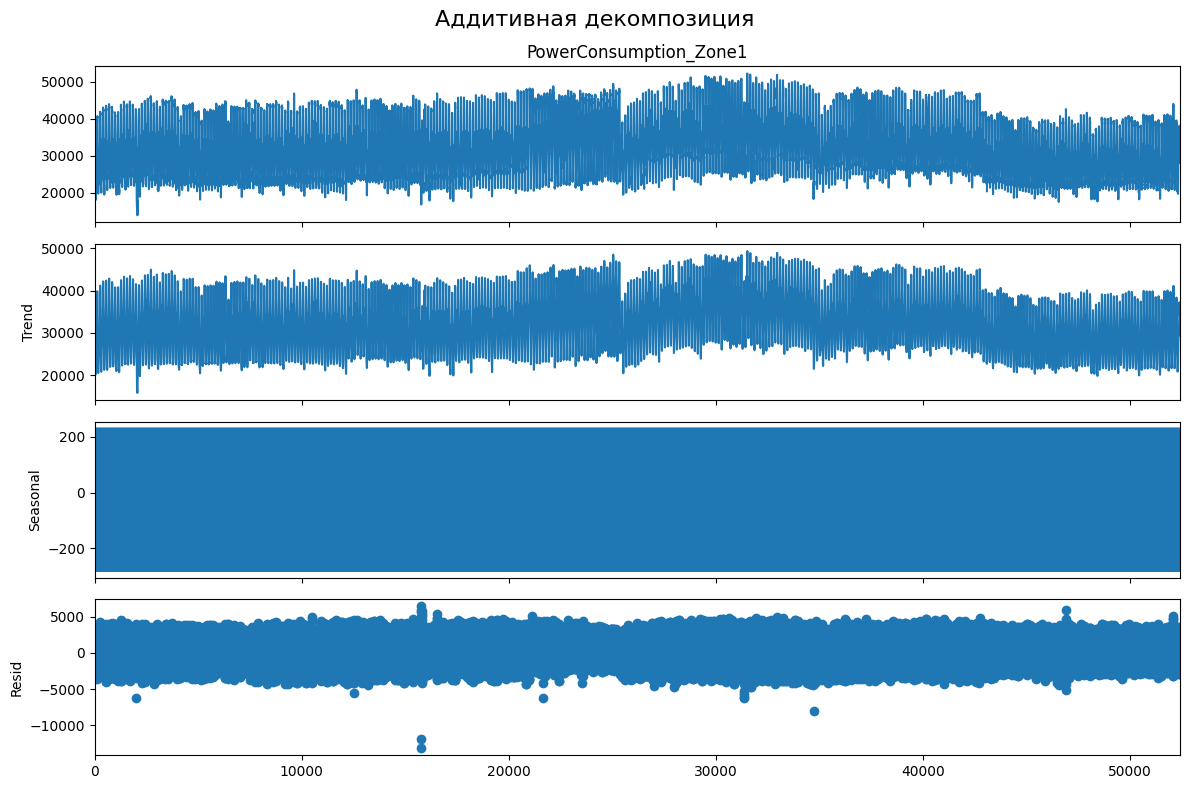

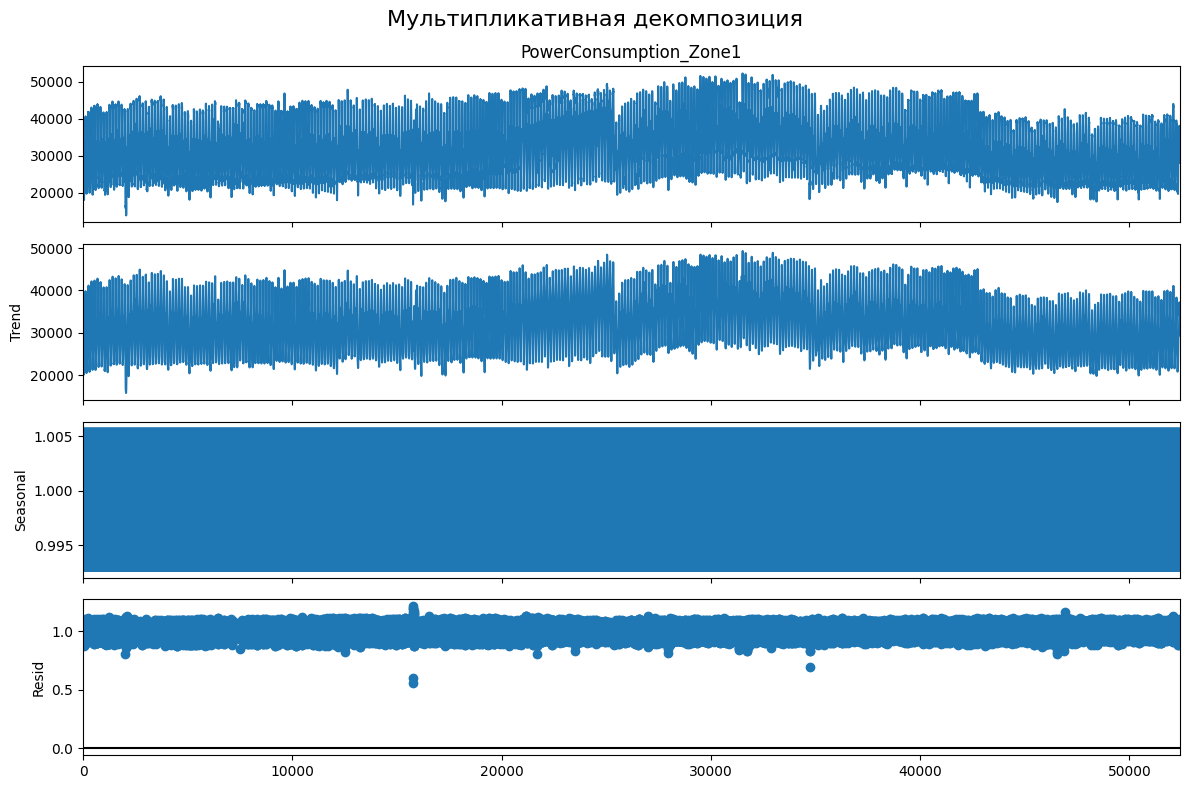

In [5]:
series = df['PowerConsumption_Zone1']

add_decomp = additive_decomposition(series)
plot_decomposition(add_decomp, "Аддитивная декомпозиция")

mult_decomp = multiplicative_decomposition(series)
plot_decomposition(mult_decomp, "Мультипликативная декомпозиция")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')

def find_optimal_period(series, candidate_periods=[7, 24, 30, 168, 365, 8760]):
    """Находит оптимальный период сезонности используя автокорреляцию"""

    autocorr = acf(series, nlags=min(1000, len(series)//3), fft=True)

    peaks = []
    for i in range(2, len(autocorr)-1):
        if (autocorr[i] > autocorr[i-1] and
            autocorr[i] > autocorr[i+1] and
            autocorr[i] > 0.1):
            peaks.append(i)

    print("🔍 Найденные пики автокорреляции:")
    for peak in peaks[:10]:
        print(f"  Лаг {peak}: ACF = {autocorr[peak]:.3f}")

    best_period = None
    best_score = 0

    for period in candidate_periods:
        closest_peak = min(peaks, key=lambda x: abs(x - period)) if peaks else period
        score = autocorr[closest_peak] if peaks else 0

        deviation_penalty = abs(closest_peak - period) / period
        adjusted_score = score * (1 - deviation_penalty * 0.1)

        print(f"  Период {period}: ACF = {score:.3f}, скор = {adjusted_score:.3f}")

        if adjusted_score > best_score:
            best_score = adjusted_score
            best_period = period

    return best_period if best_period else candidate_periods[0]

In [7]:
print("Лучший период:", find_optimal_period(series))

🔍 Найденные пики автокорреляции:
  Лаг 144: ACF = 0.959
  Лаг 288: ACF = 0.947
  Лаг 432: ACF = 0.934
  Лаг 576: ACF = 0.928
  Лаг 720: ACF = 0.928
  Лаг 864: ACF = 0.925
  Период 7: ACF = 0.959, скор = -0.918
  Период 24: ACF = 0.959, скор = 0.479
  Период 30: ACF = 0.959, скор = 0.594
  Период 168: ACF = 0.959, скор = 0.945
  Период 365: ACF = 0.934, скор = 0.917
  Период 8760: ACF = 0.925, скор = 0.841
Лучший период: 168


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def check_stationarity(series, name="Ряд"):
    """Проверка стационарности с помощью ADF и KPSS тестов"""
    print(f"📊 Стационарность остатков ({name}):")
    print("-" * 50)

    # ADF тест (H0: ряд нестационарен)
    adf_result = adfuller(series.dropna())
    print(f"ADF тест:")
    print(f"  Статистика: {adf_result[0]:.4f}")
    print(f"  P-value: {adf_result[1]:.4f}")
    print(f"  Результат: {'✅ Стационарен' if adf_result[1] < 0.05 else '❌ Нестационарен'}")

    # KPSS тест (H0: ряд стационарен)
    try:
        kpss_result = kpss(series.dropna())
        print(f"KPSS тест:")
        print(f"  Статистика: {kpss_result[0]:.4f}")
        print(f"  P-value: {kpss_result[1]:.4f}")
        print(f"  Результат: {'✅ Стационарен' if kpss_result[1] > 0.05 else '❌ Нестационарен'}")
    except:
        print("KPSS тест: не удалось выполнить")

    print()

def plot_acf_pacf(series, title="Остатки"):
    """Построение ACF и PACF графиков"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # ACF
    plot_acf(series.dropna(), ax=ax1, lags=40, title=f'ACF - {title}')
    ax1.set_ylabel('Автокорреляция')

    # PACF
    plot_pacf(series.dropna(), ax=ax2, lags=40, title=f'PACF - {title}')
    ax2.set_ylabel('Частная автокорреляция')
    ax2.set_xlabel('Лаг')

    plt.tight_layout()
    plt.show()

def check_normality(series, title="Остатки"):
    """Проверка нормальности распределения"""
    clean_series = series.replace([np.inf, -np.inf], np.nan).dropna()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Гистограмма с нормальным распределением
    n, bins, patches = ax1.hist(clean_series, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Нормальное распределение с теми же параметрами
    mu, sigma = clean_series.mean(), clean_series.std()
    x = np.linspace(clean_series.min(), clean_series.max(), 100)
    y = stats.norm.pdf(x, mu, sigma)
    ax1.plot(x, y, 'r-', linewidth=2, label=f'N({mu:.2f}, {sigma:.2f}²)')

    ax1.set_title(f'Гистограмма {title}\n')
    ax1.set_xlabel('Значение')
    ax1.set_ylabel('Плотность')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Q-Q plot
    stats.probplot(clean_series, dist="norm", plot=ax2)
    ax2.set_title(f'Q-Q Plot {title}\n')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Статистические тесты нормальности
    print(f"📊 Тесты нормальности ({title}):")
    print("-" * 40)

    # Shapiro-Wilk test
    if len(clean_series) < 5000:  # Shapiro работает до 5000 наблюдений
        shapiro_stat, shapiro_p = stats.shapiro(clean_series)
        print(f"Shapiro-Wilk test:")
        print(f"  Статистика: {shapiro_stat:.4f}")
        print(f"  P-value: {shapiro_p:.4f}")
        print(f"  Результат: {'✅ Нормальное' if shapiro_p > 0.05 else '❌ Не нормальное'}")

    # Normaltest (D'Agostino-Pearson)
    normaltest_stat, normaltest_p = stats.normaltest(clean_series)
    print(f"D'Agostino-Pearson test:")
    print(f"  Статистика: {normaltest_stat:.4f}")
    print(f"  P-value: {normaltest_p:.4f}")
    print(f"  Результат: {'✅ Нормальное' if normaltest_p > 0.05 else '❌ Не нормальное'}")

    # Основные статистики
    print(f"\n📈 Основные статистики:")
    print(f"  Среднее: {clean_series.mean():.4f}")
    print(f"  Стандартное отклонение: {clean_series.std():.4f}")
    print(f"  Асимметрия: {stats.skew(clean_series):.4f}")
    print(f"  Эксцесс: {stats.kurtosis(clean_series):.4f}")
    print()

def analyze_residuals(residuals, name="Остатки"):
    """Полный анализ остатков"""
    print(f"🔍 АНАЛИЗ ОСТАТКОВ: {name}")
    print("=" * 60)

    check_stationarity(residuals, name)

    # ACF/PACF
    plot_acf_pacf(residuals, name)

    # Проверка нормальности
    check_normality(residuals, name)

    # Дополнительная информация
    print(f"📋 Дополнительная информация:")
    print(f"  Количество наблюдений: {len(residuals.dropna())}")
    print(f"  Пропущенные значения: {residuals.isna().sum()}")
    print(f"  Минимум: {residuals.min():.4f}")
    print(f"  Максимум: {residuals.max():.4f}")

🔍 АНАЛИЗ ОСТАТКОВ: Остатки декомпозиции
📊 Стационарность остатков (Остатки декомпозиции):
--------------------------------------------------
ADF тест:
  Статистика: -49.7659
  P-value: 0.0000
  Результат: ✅ Стационарен
KPSS тест:
  Статистика: 0.0183
  P-value: 0.1000
  Результат: ✅ Стационарен



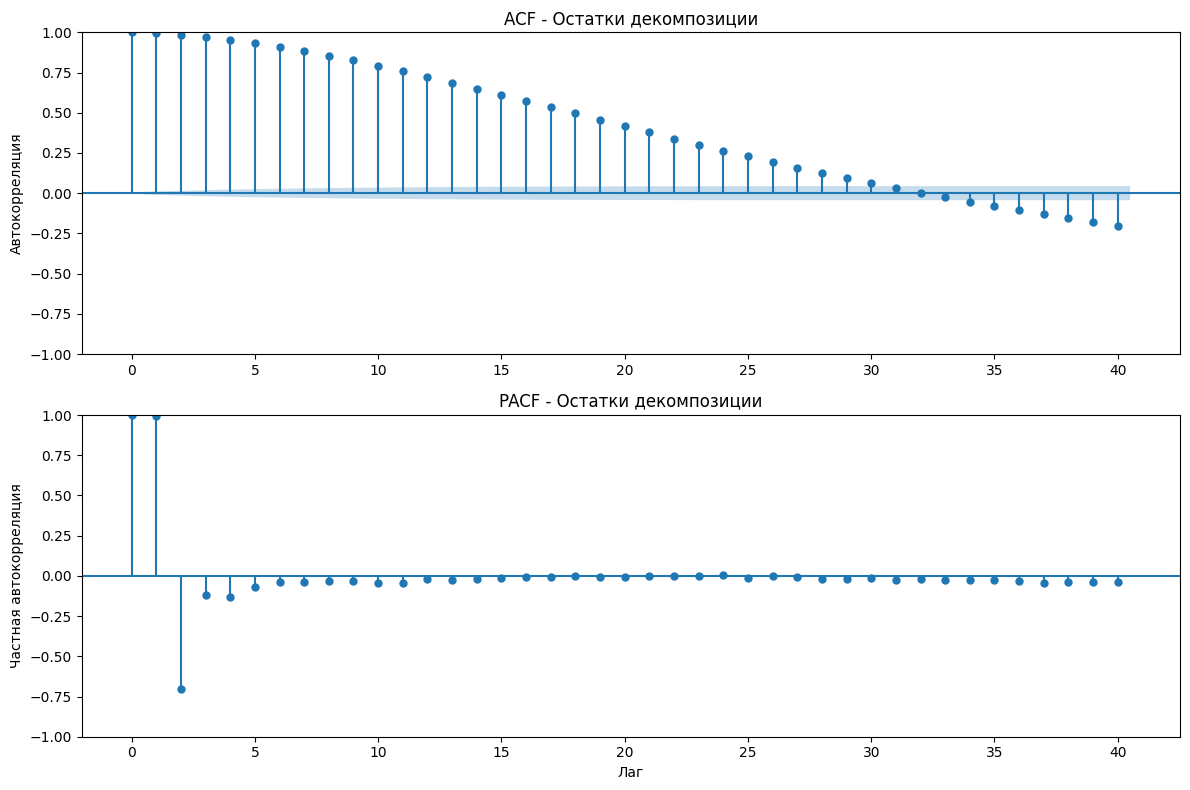

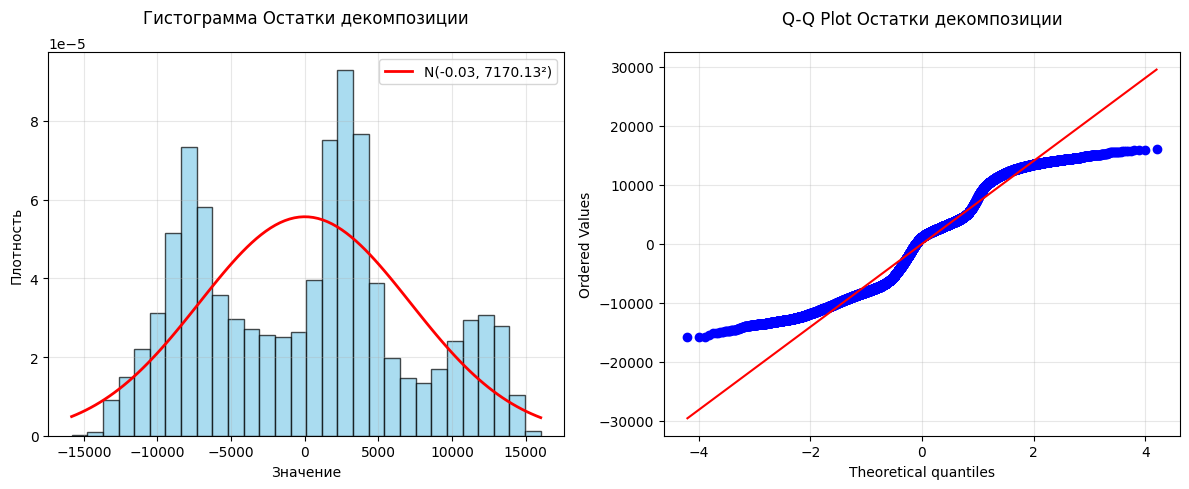

📊 Тесты нормальности (Остатки декомпозиции):
----------------------------------------
D'Agostino-Pearson test:
  Статистика: 8255.2750
  P-value: 0.0000
  Результат: ❌ Не нормальное

📈 Основные статистики:
  Среднее: -0.0295
  Стандартное отклонение: 7170.1343
  Асимметрия: 0.1501
  Эксцесс: -0.9232

📋 Дополнительная информация:
  Количество наблюдений: 52248
  Пропущенные значения: 168
  Минимум: -15829.2231
  Максимум: 16013.4496


In [9]:
# аддитивная декомпозиция
decomposition_additive = seasonal_decompose(series, model='additive', period=168)
analyze_residuals(decomposition_additive.resid, "Остатки декомпозиции")

🔍 АНАЛИЗ ОСТАТКОВ: Остатки декомпозиции
📊 Стационарность остатков (Остатки декомпозиции):
--------------------------------------------------
ADF тест:
  Статистика: -50.9122
  P-value: 0.0000
  Результат: ✅ Стационарен
KPSS тест:
  Статистика: 0.0611
  P-value: 0.1000
  Результат: ✅ Стационарен



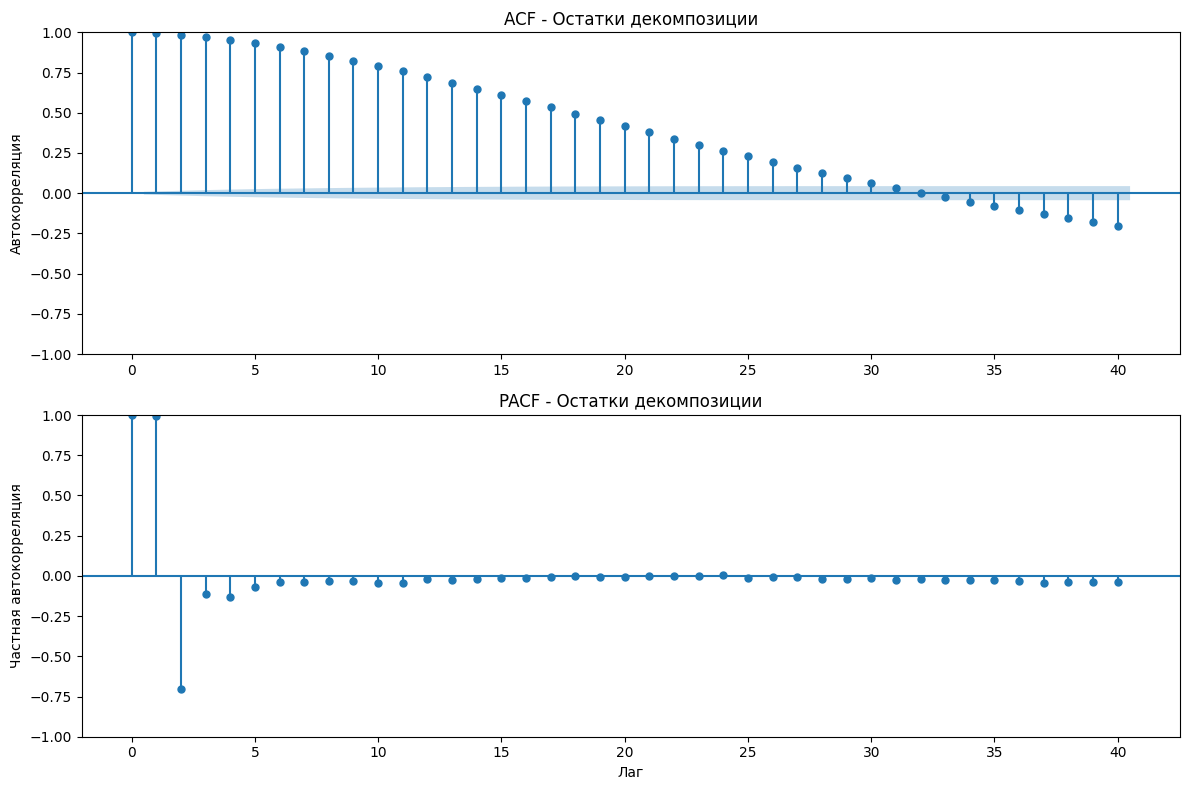

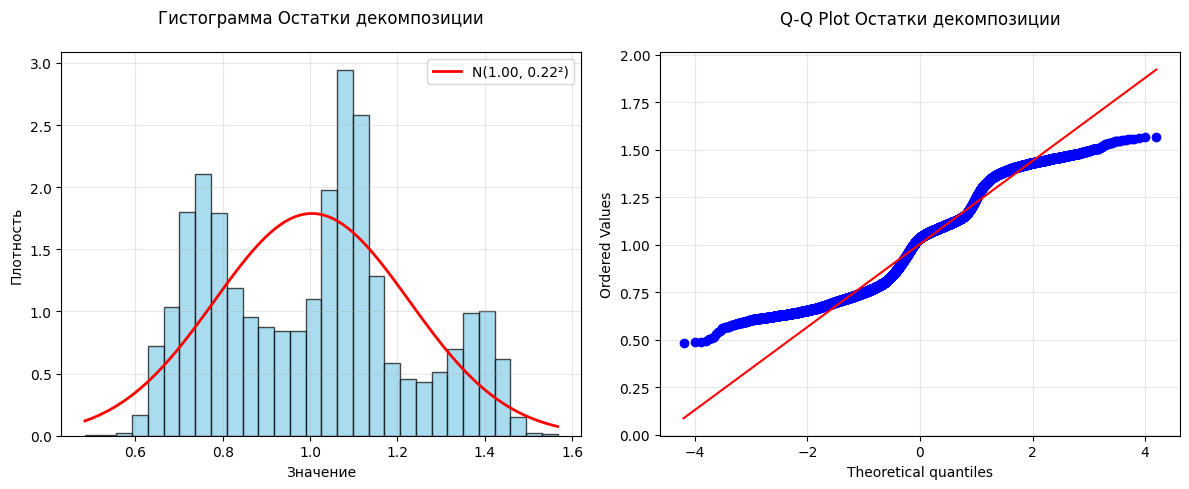

📊 Тесты нормальности (Остатки декомпозиции):
----------------------------------------
D'Agostino-Pearson test:
  Статистика: 7222.8240
  P-value: 0.0000
  Результат: ❌ Не нормальное

📈 Основные статистики:
  Среднее: 1.0040
  Стандартное отклонение: 0.2231
  Асимметрия: 0.2163
  Эксцесс: -0.8895

📋 Дополнительная информация:
  Количество наблюдений: 52248
  Пропущенные значения: 168
  Минимум: 0.4846
  Максимум: 1.5668


In [10]:
decomposition_mult = seasonal_decompose(series, model='multiplicative', period=168)

analyze_residuals(decomposition_mult.resid, "Остатки декомпозиции")

Этап 2. Расширенный feature engineering

Задача: Создать информативные признаки для прогнозирования.

📌 Что нужно сделать:
- Сгенерировать временные признаки:
  - День недели, месяц, квартал,
  - Циклические признаки через sin/cos.
  - Создать лаговые признаки: lag_1, lag_7, lag_30.
- Рассчитать скользящие статистики:
  - Среднее, std, min, max по окнам 7, 30, 90.
  - Добавить признаки волатильности (например, скользящий коэффициент вариации).


🛠️ Инструменты: pandas, numpy

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def convert_to_datetime(df, datetime_column):
    """Конвертирует столбец в datetime формат"""
    df_temp = df.copy()

    try:
        df_temp[datetime_column] = pd.to_datetime(df_temp[datetime_column])
        print(f"✅ Дата успешно сконвертирована")
    except:
        try:
            df_temp[datetime_column] = pd.to_datetime(df_temp[datetime_column], format='%m/%d/%Y %H:%M')
            print(f"✅ Дата сконвертирована с форматом '%m/%d/%Y %H:%M'")
        except:
            df_temp[datetime_column] = pd.to_datetime(df_temp[datetime_column], infer_datetime_format=True)
            print(f"✅ Дата сконвертирована с автоматическим определением формата")

    return df_temp


def create_time_features(df, datetime_column='Datetime'):
    """Создает базовые временные признаки из даты"""
    df_temp = df.copy()

    if not pd.api.types.is_datetime64_any_dtype(df_temp[datetime_column]):
        df_temp = convert_to_datetime(df_temp, datetime_column)

    df_temp['hour'] = df_temp[datetime_column].dt.hour
    df_temp['day'] = df_temp[datetime_column].dt.day
    df_temp['dayofweek'] = df_temp[datetime_column].dt.dayofweek
    df_temp['dayofyear'] = df_temp[datetime_column].dt.dayofyear
    df_temp['week'] = df_temp[datetime_column].dt.isocalendar().week
    df_temp['month'] = df_temp[datetime_column].dt.month
    df_temp['quarter'] = df_temp[datetime_column].dt.quarter
    df_temp['year'] = df_temp[datetime_column].dt.year
    df_temp['is_weekend'] = (df_temp[datetime_column].dt.dayofweek >= 5).astype(int)

    print(f"✅ Создано базовых временных признаков: {len([col for col in df_temp.columns if col not in df.columns])}")
    return df_temp


def create_cyclic_features(df, columns=['hour', 'dayofweek', 'month']):
    """Создает циклические признаки через sin/cos"""
    df_temp = df.copy()

    cyclic_mapping = {
        'hour': 24,
        'dayofweek': 7,
        'month': 12,
        'day': 31,
        'dayofyear': 365
    }

    for col in columns:
        if col in df_temp.columns:
            max_val = cyclic_mapping.get(col, df_temp[col].max())

            df_temp[f'{col}_sin'] = np.sin(2 * np.pi * df_temp[col] / max_val)
            df_temp[f'{col}_cos'] = np.cos(2 * np.pi * df_temp[col] / max_val)

            print(f"  🔄 {col}: sin({col}), cos({col})")

    print(f"✅ Создано циклических признаков: {len([col for col in df_temp.columns if '_sin' in col or '_cos' in col])}")
    return df_temp


def create_lag_features(df, value_column, lags=[1, 7, 24, 30, 168]):
    """Создает лаговые признаки"""
    df_temp = df.copy()

    for lag in lags:
        df_temp[f'lag_{lag}'] = df_temp[value_column].shift(lag)
        print(f"  ⏪ lag_{lag}")

    print(f"✅ Создано лаговых признаков: {len([col for col in df_temp.columns if 'lag_' in col])}")
    return df_temp


def create_rolling_features(df, value_column, windows=[3, 7, 24, 30]):
    """Создает скользящие статистики"""
    df_temp = df.copy()

    for window in windows:
        df_temp[f'rolling_mean_{window}'] = df_temp[value_column].rolling(window=window).mean()
        df_temp[f'rolling_std_{window}'] = df_temp[value_column].rolling(window=window).std()
        df_temp[f'rolling_min_{window}'] = df_temp[value_column].rolling(window=window).min()
        df_temp[f'rolling_max_{window}'] = df_temp[value_column].rolling(window=window).max()

        print(f"  📊 rolling stats (window={window})")

    print(f"✅ Создано скользящих признаков: {len([col for col in df_temp.columns if 'rolling_' in col])}")
    return df_temp


def create_all_features(df, datetime_column='Datetime', value_column='value',
                       include_cyclic=True, include_lags=True, include_rolling=True):
    """Создает все временные признаки одной функцией"""
    print("🎯 Начинаем генерацию признаков...")
    print("-" * 50)

    df_features = df.copy()

    if not pd.api.types.is_datetime64_any_dtype(df_features[datetime_column]):
        df_features = convert_to_datetime(df_features, datetime_column)

    df_features = create_time_features(df_features, datetime_column)

    if include_cyclic:
        df_features = create_cyclic_features(df_features)

    if include_lags:
        df_features = create_lag_features(df_features, value_column)

    if include_rolling:
        df_features = create_rolling_features(df_features, value_column)

    original_cols = len(df.columns)
    new_cols = len(df_features.columns) - original_cols

    print("-" * 50)
    print(f"🎉 Генерация завершена!")
    print(f"📊 Исходные колонки: {original_cols}")
    print(f"📈 Новые признаки: {new_cols}")
    print(f"📋 Всего колонок: {len(df_features.columns)}")

    return df_features


def prepare_datetime_data(df, datetime_col, value_col):
    """Подготовка данных с датой в формате '1/1/2017 0:00'"""
    df_prepared = df.copy()

    df_prepared[datetime_col] = pd.to_datetime(df_prepared[datetime_col], format='%m/%d/%Y %H:%M')

    df_prepared = df_prepared.sort_values(datetime_col).reset_index(drop=True)

    print(f"✅ Данные подготовлены:")
    print(f"   Первая дата: {df_prepared[datetime_col].min()}")
    print(f"   Последняя дата: {df_prepared[datetime_col].max()}")
    print(f"   Всего записей: {len(df_prepared)}")

    return df_prepared

In [12]:
df_with_features = create_all_features(
    df,
    datetime_column='Datetime',
    value_column='PowerConsumption_Zone1'
)

print(df_with_features.iloc[100:105][['Datetime', 'hour', 'hour_sin', 'hour_cos', 'lag_1', 'lag_7', 'rolling_mean_24']])

🎯 Начинаем генерацию признаков...
--------------------------------------------------
✅ Дата успешно сконвертирована
✅ Создано базовых временных признаков: 9
  🔄 hour: sin(hour), cos(hour)
  🔄 dayofweek: sin(dayofweek), cos(dayofweek)
  🔄 month: sin(month), cos(month)
✅ Создано циклических признаков: 6
  ⏪ lag_1
  ⏪ lag_7
  ⏪ lag_24
  ⏪ lag_30
  ⏪ lag_168
✅ Создано лаговых признаков: 5
  📊 rolling stats (window=3)
  📊 rolling stats (window=7)
  📊 rolling stats (window=24)
  📊 rolling stats (window=30)
✅ Создано скользящих признаков: 16
--------------------------------------------------
🎉 Генерация завершена!
📊 Исходные колонки: 9
📈 Новые признаки: 36
📋 Всего колонок: 45
               Datetime  hour  hour_sin  hour_cos        lag_1        lag_7  \
100 2017-01-01 16:40:00    16 -0.866025 -0.500000  28514.43038  29061.26582   
101 2017-01-01 16:50:00    16 -0.866025 -0.500000  28666.32911  28885.06329   
102 2017-01-01 17:00:00    17 -0.965926 -0.258819  29097.72152  28854.68354   
103 20

In [13]:
import pandas as pd
import numpy as np

def create_rolling_stats(series, windows=[7, 30, 90]):
    """Рассчитывает скользящие статистики для временного ряда"""

    result = {}

    for window in windows:
        result[f'rolling_mean_{window}'] = series.rolling(window=window).mean()
        result[f'rolling_std_{window}'] = series.rolling(window=window).std()
        result[f'rolling_min_{window}'] = series.rolling(window=window).min()
        result[f'rolling_max_{window}'] = series.rolling(window=window).max()

    return result

In [14]:
create_rolling_stats(df_with_features['PowerConsumption_Zone1'])

{'rolling_mean_7': 0                 NaN
 1                 NaN
 2                 NaN
 3                 NaN
 4                 NaN
              ...     
 52411    33194.133623
 52412    32578.815860
 52413    31902.661596
 52414    31214.340030
 52415    30494.731123
 Name: PowerConsumption_Zone1, Length: 52416, dtype: float64,
 'rolling_std_7': 0                NaN
 1                NaN
 2                NaN
 3                NaN
 4                NaN
             ...     
 52411    1250.855856
 52412    1413.814776
 52413    1563.928080
 52414    1659.203100
 52415    1652.152050
 Name: PowerConsumption_Zone1, Length: 52416, dtype: float64,
 'rolling_min_7': 0                NaN
 1                NaN
 2                NaN
 3                NaN
 4                NaN
             ...     
 52411    31160.45627
 52412    30430.41825
 52413    29590.87452
 52414    28958.17490
 52415    28349.80989
 Name: PowerConsumption_Zone1, Length: 52416, dtype: float64,
 'rolling_max_7': 0      

In [15]:
create_rolling_stats(df_with_features['PowerConsumption_Zone2'])

{'rolling_mean_7': 0                 NaN
 1                 NaN
 2                 NaN
 3                 NaN
 4                 NaN
              ...     
 52411    27935.650727
 52412    27505.895763
 52413    27020.383116
 52414    26514.881866
 52415    25977.819664
 Name: PowerConsumption_Zone2, Length: 52416, dtype: float64,
 'rolling_std_7': 0                NaN
 1                NaN
 2                NaN
 3                NaN
 4                NaN
             ...     
 52411     798.212917
 52412     854.078950
 52413    1026.461173
 52414    1189.418774
 52415    1343.483590
 Name: PowerConsumption_Zone2, Length: 52416, dtype: float64,
 'rolling_min_7': 0                NaN
 1                NaN
 2                NaN
 3                NaN
 4                NaN
             ...     
 52411    26857.31820
 52412    26124.57809
 52413    25277.69254
 52414    24692.23688
 52415    24055.23167
 Name: PowerConsumption_Zone2, Length: 52416, dtype: float64,
 'rolling_max_7': 0      

In [16]:
create_rolling_stats(df_with_features['PowerConsumption_Zone3'])

{'rolling_mean_7': 0                 NaN
 1                 NaN
 2                 NaN
 3                 NaN
 4                 NaN
              ...     
 52411    15343.371634
 52412    15142.514147
 52413    14874.155374
 52414    14583.570569
 52415    14290.516204
 Name: PowerConsumption_Zone3, Length: 52416, dtype: float64,
 'rolling_std_7': 0               NaN
 1               NaN
 2               NaN
 3               NaN
 4               NaN
             ...    
 52411    381.934254
 52412    444.923440
 52413    601.985897
 52414    705.307289
 52415    736.538888
 Name: PowerConsumption_Zone3, Length: 52416, dtype: float64,
 'rolling_min_7': 0                NaN
 1                NaN
 2                NaN
 3                NaN
 4                NaN
             ...     
 52411    14780.31212
 52412    14428.81152
 52413    13806.48259
 52414    13512.60504
 52415    13345.49820
 Name: PowerConsumption_Zone3, Length: 52416, dtype: float64,
 'rolling_max_7': 0                N

Этап 3. Стратегии многопшагового прогнозирования


Задача: Реализовать и сравнить три подхода к прогнозу на h ≥ 7 шагов.


📌 Что нужно сделать:
- Рекурсивная стратегия: одна модель → итеративное использование прогнозов.
- Прямая стратегия: отдельная модель для каждого шага t+1, ..., t+h.
- Гибридная стратегия: например, рекурсивная для ближайших шагов, прямая — для дальних.


Сравнить по:
- Точности (MAE, RMSE на каждом шаге),
- Времени вычислений,
- Накоплению ошибки.

In [17]:
import time

Рекурсивная стратегия

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression

def create_recursive_features(data, lag):
    """Создает признаки для рекурсивного прогнозирования"""
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i])  # история до момента t
        y.append(data[i])        # значение в момент t
    return np.array(X), np.array(y)

def recursive_forecast(train_series, test_horizon, lag=5, model=None):
    """
    Рекурсивная стратегия прогнозирования

    Args:
        train_series: обучающий временной ряд
        test_horizon: горизонт прогнозирования (h)
        lag: глубина истории для признаков
        model: модель для прогнозирования (по умолчанию LinearRegression)
    """
    if model is None:
        model = LinearRegression()

    # Обучаем модель на исторических данных
    X_train, y_train = create_recursive_features(train_series, lag)
    model.fit(X_train, y_train)

    # Начинаем с последних lag значений обучающей выборки
    current_window = train_series[-lag:].copy()
    predictions = []

    # Рекурсивно строим прогноз на h шагов вперед
    for _ in range(test_horizon):
        # Прогноз на один шаг
        next_pred = model.predict(current_window.reshape(1, -1))[0]
        predictions.append(next_pred)

        # Обновляем окно: убираем самое старое значение, добавляем прогноз
        current_window = np.append(current_window[1:], next_pred)

    return np.array(predictions)

In [19]:
series = df_with_features['PowerConsumption_Zone1']

train, test = series[:-7].values, series[-7:].values

h = 7
lag = 200

start_time = time.time()
preds = recursive_forecast(train, h, lag)
end_time = time.time()

print(f"Прогноз на {h} шагов: {preds.round(3)}")
print(f"Фактические значения: {test.round(3)}")
print(f"MAE: {np.mean(np.abs(preds - test)):.3f}")
print(f"RMSE: {np.sqrt(np.mean((test - preds) ** 2))}")
print(f"Time: {np.mean(np.abs(end_time - start_time)):.3f}")

Прогноз на 7 шагов: [32921.383 32383.276 31793.441 31203.913 30557.822 29742.98  28995.587]
Фактические значения: [32815.209 32158.175 31160.456 30430.418 29590.875 28958.175 28349.81 ]
MAE: 590.755
RMSE: 657.7930361342621
Time: 0.871


Прямой метод

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression

def create_direct_features(data, lag, horizon):
    """Создает признаки для прямой стратегии"""
    X, y = [], []
    for i in range(lag, len(data) - horizon + 1):
        X.append(data[i-lag:i])  # история до момента t
        # Целевые метки для горизонта h
        y.append(data[i:i+horizon])
    return np.array(X), np.array(y)

def direct_forecast(train_series, test_horizon, lag=5, model_class=None):
    """
    Прямая стратегия прогнозирования

    Args:
        train_series: обучающий ряд
        test_horizon: горизонт прогнозирования (h)
        lag: глубина истории
        model_class: класс модели (по умолчанию LinearRegression)
    """
    if model_class is None:
        model_class = LinearRegression

    if hasattr(train_series, 'values'):
        train_series = train_series.values

    models = []

    for h in range(1, test_horizon + 1):
        X_train, y_train = [], []
        for i in range(lag, len(train_series) - h + 1):
            X_train.append(train_series[i-lag:i])
            y_train.append(train_series[i + h - 1])

        X_train, y_train = np.array(X_train), np.array(y_train)

        model = model_class()
        model.fit(X_train, y_train)
        models.append(model)

    current_window = train_series[-lag:]
    predictions = []

    for h, model in enumerate(models, 1):
        pred = model.predict(current_window.reshape(1, -1))[0]
        predictions.append(pred)

    return np.array(predictions)

In [21]:
train, test = series[:-7], series[-7:]

h = 7
lag = 200

start_time = time.time()
preds_direct = direct_forecast(train, h, lag)
end_time = time.time()


print(f"Прямая стратегия - Прогноз на {h} шагов: {preds_direct.round(3)}")
print(f"Фактические значения:\n{test.round(3)}")
print(f"MAE: {np.mean(np.abs(preds_direct - test)):.3f}")
print(f"RMSE: {np.sqrt(np.mean((test - preds_direct) ** 2))}")
print(f"Time: {np.mean(np.abs(end_time - start_time)):.3f}")

Прямая стратегия - Прогноз на 7 шагов: [32921.383 32383.998 31791.835 31202.3   30556.05  29741.069 28989.849]
Фактические значения:
52409    32815.209
52410    32158.175
52411    31160.456
52412    30430.418
52413    29590.875
52414    28958.175
52415    28349.810
Name: PowerConsumption_Zone1, dtype: float64
MAE: 589.052
RMSE: 655.8359763587429
Time: 18.134


Гибридный метод

In [22]:
def hybrid_forecast(train_series, test_horizon, lag=5, model_class=None):
    """
    Исправленная гибридная стратегия
    """
    if model_class is None:
        model_class = LinearRegression

    train_data = train_series.values if hasattr(train_series, 'values') else train_series

    models = []
    predictions = []

    for h in range(1, test_horizon + 1):
        X_train, y_train = [], []

        for i in range(lag, len(train_data) - h + 1):
            # Всегда начинаем с базовых признаков
            features = list(train_data[i-lag:i])

            # Добавляем РЕАЛЬНЫЕ значения для предыдущих шагов (не прогнозы!)
            for prev_h in range(1, h):
                if i + prev_h - 1 < len(train_data):
                    features.append(train_data[i + prev_h - 1])

            X_train.append(features)
            y_train.append(train_data[i + h - 1])

        # Обучаем модель
        model = model_class()
        X_train_arr = np.array(X_train)
        y_train_arr = np.array(y_train)
        model.fit(X_train_arr, y_train_arr)
        models.append(model)

        # Прогнозирование
        current_features = list(train_data[-lag:])  # базовые признаки

        # Добавляем уже сделанные прогнозы для предыдущих шагов
        for prev_pred in predictions:
            current_features.append(prev_pred)

        # Проверяем соответствие размерности
        expected_features = models[h-1].n_features_in_
        if len(current_features) != expected_features:
            # Если не хватает признаков, дополняем последним известным значением
            while len(current_features) < expected_features:
                current_features.append(train_data[-1])

        pred = model.predict([current_features])[0]
        predictions.append(pred)

    return np.array(predictions)

In [23]:
train, test = series[:-7], series[-7:]

h = 7
lag = 200

start_time = time.time()
preds_hybrid = hybrid_forecast(train, h, lag)
end_time = time.time()


print(f"Прямая стратегия - Прогноз на {h} шагов: {preds_direct.round(3)}")
print(f"Фактические значения:\n{test.round(3)}")
print(f"MAE: {np.mean(np.abs(preds_direct - test)):.3f}")
print(f"RMSE: {np.sqrt(np.mean((test - preds_hybrid) ** 2))}")
print(f"Time: {np.mean(np.abs(end_time - start_time)):.3f}")

Прямая стратегия - Прогноз на 7 шагов: [32921.383 32383.998 31791.835 31202.3   30556.05  29741.069 28989.849]
Фактические значения:
52409    32815.209
52410    32158.175
52411    31160.456
52412    30430.418
52413    29590.875
52414    28958.175
52415    28349.810
Name: PowerConsumption_Zone1, dtype: float64
MAE: 589.052
RMSE: 655.9511209756382
Time: 23.289


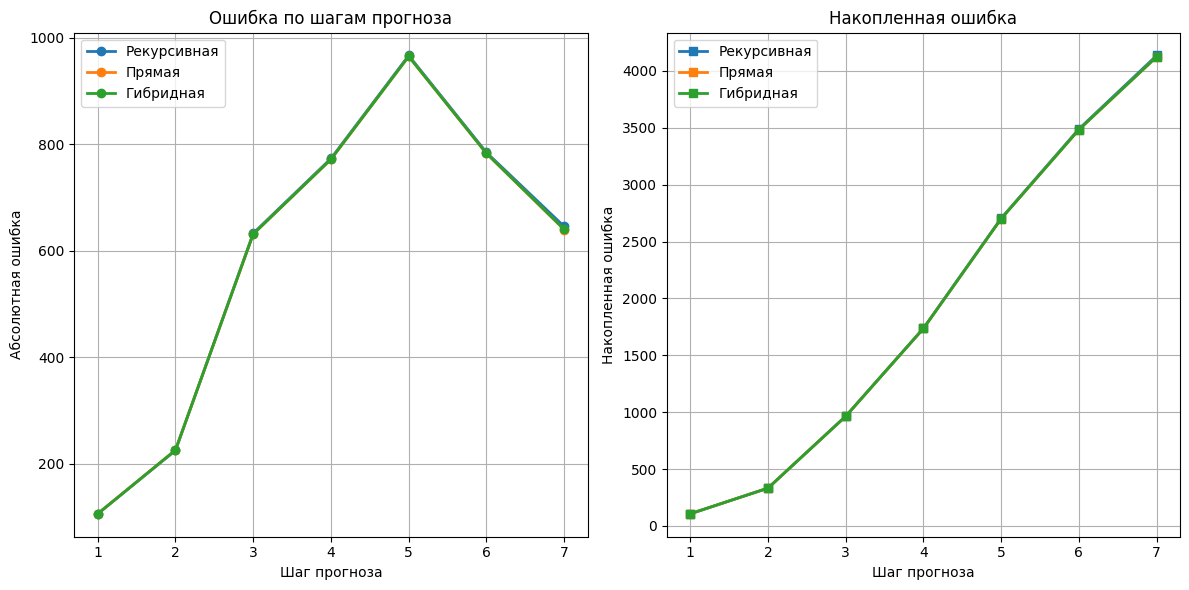

In [24]:
def analyze_error_propagation(y_true, y_pred_list, model_names):
    """
    Анализ накопления ошибок по шагам прогноза
    """
    horizons = range(1, len(y_true) + 1)

    plt.figure(figsize=(12, 6))

    for i, (y_pred, name) in enumerate(zip(y_pred_list, model_names)):
        errors = np.abs(y_true - y_pred)

        plt.subplot(1, 2, 1)
        plt.plot(horizons, errors, marker='o', label=name, linewidth=2)

        plt.subplot(1, 2, 2)
        cumulative_errors = np.cumsum(errors)
        plt.plot(horizons, cumulative_errors, marker='s', label=name, linewidth=2)

    plt.subplot(1, 2, 1)
    plt.xlabel('Шаг прогноза')
    plt.ylabel('Абсолютная ошибка')
    plt.title('Ошибка по шагам прогноза')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.xlabel('Шаг прогноза')
    plt.ylabel('Накопленная ошибка')
    plt.title('Накопленная ошибка')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

train, test = series[:-7].values, series[-7:].values
preds_recursive = recursive_forecast(train, test_horizon=7, lag=200)
preds_direct = direct_forecast(train, test_horizon=7, lag=200)
preds_hybrid = hybrid_forecast(train, test_horizon=7, lag=200)

analyze_error_propagation(
    test,
    [preds_recursive, preds_direct, preds_hybrid],
    ['Рекурсивная', 'Прямая', 'Гибридная']
)

Этап 4. Кросс-валидация для временных рядов


Задача: Оценить качество моделей без утечки будущего.

📌 Что нужно сделать:

- Реализовать скользящее окно: фиксированная длина обучения, сдвиг по времени.

- Реализовать расширяющееся окно: обучение растёт со временем.

- Настроить TimeSeriesSplit (sklearn.model_selection).

- Для каждой схемы:
  - Оценить среднее качество по фолдам,
  - Проанализировать стабильность метрик во времени.
  
📊 Визуализируйте динамику ошибки по фолдам.

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def time_series_cv(series, forecast_func, min_train_size=50, step=1, h=7, **kwargs):
    """
    Схема кросс-валидации со скользящим окном

    Args:
        series: весь временной ряд
        forecast_func: функция прогнозирования
        min_train_size: минимальный размер обучающей выборки
        step: шаг между фолдами
        h: горизонт прогнозирования
        **kwargs: аргументы для forecast_func

    Returns:
        cv_scores: словарь с метриками по фолдам
    """
    n = len(series)
    cv_scores = {
        'rmse': [],
        'mae': [],
        'predictions': [],
        'true_values': []
    }

    # Проходим по всем возможным фолдам
    for i in range(min_train_size, n - h + 1, step):
        # Разделяем на train/test
        train = series[:i]
        test = series[i:i+h]

        # Строим прогноз
        try:
            preds = forecast_func(train, h=h, **kwargs)

            # Обрезаем прогноз если тестовая выборка меньше h
            actual_test = test[:len(preds)]
            actual_preds = preds[:len(actual_test)]

            # Вычисляем метрики
            if len(actual_test) > 0:
                rmse_fold = np.sqrt(mean_squared_error(actual_test, actual_preds))
                mae_fold = mean_absolute_error(actual_test, actual_preds)

                cv_scores['rmse'].append(rmse_fold)
                cv_scores['mae'].append(mae_fold)
                cv_scores['predictions'].append(actual_preds)
                cv_scores['true_values'].append(actual_test)

        except Exception as e:
            print(f"Ошибка на фолде {i}: {e}")
            continue

    return cv_scores

def expanding_window_cv(series, forecast_func, initial_size=50, step=1, h=7, **kwargs):
    """
    Схема кросс-валидации с расширяющимся окном
    """
    n = len(series)
    cv_scores = {
        'rmse': [],
        'mae': [],
        'predictions': [],
        'true_values': []
    }

    train_size = initial_size

    while train_size <= n - h:
        train = series[:train_size]
        test = series[train_size:train_size+h]

        try:
            preds = forecast_func(train, h=h, **kwargs)

            actual_test = test[:len(preds)]
            actual_preds = preds[:len(actual_test)]

            if len(actual_test) > 0:
                rmse_fold = np.sqrt(mean_squared_error(actual_test, actual_preds))
                mae_fold = mean_absolute_error(actual_test, actual_preds)

                cv_scores['rmse'].append(rmse_fold)
                cv_scores['mae'].append(mae_fold)
                cv_scores['predictions'].append(actual_preds)
                cv_scores['true_values'].append(actual_test)

        except Exception as e:
            print(f"Ошибка на фолде (train_size={train_size}): {e}")

        train_size += step

    return cv_scores

In [26]:
def analyze_cv_results(cv_scores, model_name=""):
    """
    Анализ результатов кросс-валидации
    """
    rmse_scores = cv_scores['rmse']
    mae_scores = cv_scores['mae']

    print(f"\n{'='*50}")
    print(f"РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ: {model_name}")
    print(f"{'='*50}")
    print(f"Количество фолдов: {len(rmse_scores)}")
    print(f"RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")
    print(f"MAE:  {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")
    print(f"Min RMSE: {np.min(rmse_scores):.3f}")
    print(f"Max RMSE: {np.max(rmse_scores):.3f}")

    return {
        'mean_rmse': np.mean(rmse_scores),
        'std_rmse': np.std(rmse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_mae': np.std(mae_scores)
    }

In [27]:
def time_series_cv_few_folds(series, forecast_func, n_folds=5, initial_size=0.7, h=7, **kwargs):
    """
    Кросс-валидация с малым количеством фолдов

    Args:
        series: весь временной ряд
        forecast_func: функция прогнозирования
        n_folds: количество фолдов (3-10)
        initial_size: доля данных для начального обучения (0.6-0.8)
        h: горизонт прогнозирования
        **kwargs: аргументы для forecast_func
    """
    n = len(series)
    initial_train_size = int(n * initial_size)

    cv_scores = {
        'rmse': [],
        'mae': [],
        'predictions': [],
        'true_values': [],
        'train_sizes': []
    }

    step = max(1, (n - initial_train_size - h) // n_folds)

    print(f"Всего данных: {n}")
    print(f"Начальный размер обучения: {initial_train_size}")
    print(f"Количество фолдов: {n_folds}")
    print(f"Шаг между фолдами: {step}")

    for fold in range(n_folds):
        train_size = initial_train_size + fold * step

        if train_size + h > n:
            break

        train = series[:train_size]
        test = series[train_size:train_size+h]

        try:
            preds = forecast_func(train, h=h, **kwargs)

            rmse_fold = np.sqrt(mean_squared_error(test, preds))
            mae_fold = mean_absolute_error(test, preds)

            cv_scores['rmse'].append(rmse_fold)
            cv_scores['mae'].append(mae_fold)
            cv_scores['predictions'].append(preds)
            cv_scores['true_values'].append(test)
            cv_scores['train_sizes'].append(len(train))

            print(f"Фолд {fold+1}: train_size={train_size}, RMSE={rmse_fold:.3f}")

        except Exception as e:
            print(f"Ошибка на фолде {fold+1}: {e}")
            continue

    return cv_scores

In [28]:
def time_series_cv_fixed_folds(series, forecast_func, train_sizes=None, h=7, **kwargs):
    """
    Кросс-валидация с фиксированными размерами обучающей выборки
    """
    if train_sizes is None:
        n = len(series)
        train_sizes = [
            int(n * 0.6),
            int(n * 0.7),
            int(n * 0.8),
            int(n * 0.85),
            int(n * 0.9),
        ]

    cv_scores = {
        'rmse': [],
        'mae': [],
        'predictions': [],
        'true_values': [],
        'train_sizes': []
    }

    for i, train_size in enumerate(train_sizes):
        if train_size + h > len(series):
            continue

        train = series[:train_size]
        test = series[train_size:train_size+h]

        try:
            preds = forecast_func(train, h=h, **kwargs)

            rmse_fold = np.sqrt(mean_squared_error(test, preds))
            mae_fold = mean_absolute_error(test, preds)

            cv_scores['rmse'].append(rmse_fold)
            cv_scores['mae'].append(mae_fold)
            cv_scores['predictions'].append(preds)
            cv_scores['true_values'].append(test)
            cv_scores['train_sizes'].append(train_size)

            print(f"Фолд {i+1}: train_size={train_size}, RMSE={rmse_fold:.3f}")

        except Exception as e:
            print(f"Ошибка на фолде {i+1}: {e}")
            continue

    return cv_scores

In [29]:
def time_series_cv_3_folds(series, forecast_func, h=7, **kwargs):
    """
    Всего 3 фолда для быстрой оценки
    """
    n = len(series)

    train_sizes = [
        int(n * 0.6),
        int(n * 0.75),
        int(n * 0.85),
    ]

    return time_series_cv_fixed_folds(series, forecast_func, train_sizes, h, **kwargs)

In [31]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def sklearn_ts_cv(series, forecast_func, n_splits=5, test_size=7, **kwargs):
    """
    Кросс-валидация с использованием TimeSeriesSplit
    """
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.values if hasattr(series, 'values') else series

    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        test_size=test_size,
        gap=0
    )

    cv_scores = {
        'rmse': [],
        'mae': [],
        'predictions': [],
        'true_values': [],
        'train_sizes': [],
        'test_indices': []
    }

    fold = 1
    for train_idx, test_idx in tscv.split(X):
        train_data = y[train_idx]
        test_data = y[test_idx]

        if len(train_data) < kwargs.get('lag', 5) + 1:
            continue

        try:
            preds = forecast_func(train_data, h=len(test_data), **kwargs)

            rmse_fold = np.sqrt(mean_squared_error(test_data, preds))
            mae_fold = mean_absolute_error(test_data, preds)

            cv_scores['rmse'].append(rmse_fold)
            cv_scores['mae'].append(mae_fold)
            cv_scores['predictions'].append(preds)
            cv_scores['true_values'].append(test_data)
            cv_scores['train_sizes'].append(len(train_data))
            cv_scores['test_indices'].append(test_idx)

            print(f"Фолд {fold}: train_size={len(train_data)}, test_size={len(test_data)}, RMSE={rmse_fold:.3f}")
            fold += 1

        except Exception as e:
            print(f"Ошибка на фолде {fold}: {e}")
            continue

    return cv_scores

In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Исправляем все функции прогнозирования
def recursive_forecast(train_series, h, lag=5, model=None):
    """Рекурсивная стратегия с правильными аргументами"""
    if model is None:
        model = LinearRegression()

    if hasattr(train_series, 'values'):
        train_series = train_series.values

    # Создаем признаки
    X_train, y_train = [], []
    for i in range(lag, len(train_series)):
        X_train.append(train_series[i-lag:i])
        y_train.append(train_series[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
    model.fit(X_train, y_train)

    # Рекурсивный прогноз
    current_window = train_series[-lag:]
    predictions = []

    for _ in range(h):
        next_pred = model.predict(current_window.reshape(1, -1))[0]
        predictions.append(next_pred)
        current_window = np.append(current_window[1:], next_pred)

    return np.array(predictions)

def direct_forecast_efficient(train_series, h, lag=5, model_class=None):
    """Прямая стратегия с правильными аргументами"""
    if model_class is None:
        model_class = LinearRegression

    if hasattr(train_series, 'values'):
        train_series = train_series.values

    # Создаем общую матрицу признаков
    X_train = []
    max_possible = len(train_series) - h - lag + 1

    for i in range(lag, lag + max_possible):
        X_train.append(train_series[i-lag:i])
    X_train = np.array(X_train)

    # Обучаем h моделей
    models = []
    for horizon in range(1, h + 1):
        y_train = train_series[lag + horizon - 1:lag + max_possible + horizon - 1]

        model = model_class()
        model.fit(X_train, y_train)
        models.append(model)

    # Прогнозирование
    current_window = train_series[-lag:]
    predictions = [model.predict(current_window.reshape(1, -1))[0]
                   for model in models]

    return np.array(predictions)

def hybrid_forecast_simple(train_series, h, lag=5, model_class=None):
    """Гибридная стратегия с правильными аргументами"""
    if model_class is None:
        model_class = LinearRegression

    train_data = train_series.values if hasattr(train_series, 'values') else train_series
    predictions = []

    for horizon in range(1, h + 1):
        X_train, y_train = [], []

        # Создаем обучающие данные для горизонта h
        for i in range(lag, len(train_data) - horizon + 1):
            features = []

            # 1. Базовые признаки (история)
            features.extend(train_data[i-lag:i])

            # 2. "Идеальные прогнозы" - реальные значения предыдущих шагов
            for prev_h in range(1, horizon):
                real_prev_value = train_data[i + prev_h - 1]
                features.append(real_prev_value)

            X_train.append(features)
            y_train.append(train_data[i + horizon - 1])

        # Обучаем модель
        model = model_class()
        if len(X_train) > 0:  # Проверяем, что есть данные для обучения
            model.fit(np.array(X_train), np.array(y_train))

        # Прогнозирование
        current_features = list(train_data[-lag:])
        for prev_pred in predictions:
            current_features.append(prev_pred)

        # Делаем прогноз
        if len(X_train) > 0:
            pred = model.predict([current_features])[0]
        else:
            # Если нет данных для обучения, используем последнее значение
            pred = train_data[-1]

        predictions.append(pred)

    return np.array(predictions)

# Улучшенная функция кросс-валидации
def time_series_cv(series, forecast_func, min_train_size=50, step=1, h=7, **kwargs):
    """
    Схема кросс-валидации со скользящим окном
    """
    n = len(series)
    cv_scores = {
        'rmse': [],
        'mae': [],
        'predictions': [],
        'true_values': [],
        'train_sizes': []
    }

    # Проходим по всем возможным фолдам
    for i in range(min_train_size, n - h + 1, step):
        # Разделяем на train/test
        train = series[:i]
        test = series[i:i+h]

        # Строим прогноз
        try:
            preds = forecast_func(train, h=h, **kwargs)

            # Обрезаем прогноз если тестовая выборка меньше h
            actual_test = test[:len(preds)]
            actual_preds = preds[:len(actual_test)]

            # Вычисляем метрики
            if len(actual_test) > 0:
                rmse_fold = np.sqrt(mean_squared_error(actual_test, actual_preds))
                mae_fold = mean_absolute_error(actual_test, actual_preds)

                cv_scores['rmse'].append(rmse_fold)
                cv_scores['mae'].append(mae_fold)
                cv_scores['predictions'].append(actual_preds)
                cv_scores['true_values'].append(actual_test)
                cv_scores['train_sizes'].append(len(train))

        except Exception as e:
            print(f"Ошибка на фолде {i}: {e}")
            continue

    return cv_scores

def analyze_cv_results(cv_scores, model_name=""):
    """
    Анализ результатов кросс-валидации
    """
    rmse_scores = cv_scores['rmse']
    mae_scores = cv_scores['mae']

    if len(rmse_scores) == 0:
        print(f"Нет данных для модели {model_name}")
        return None

    print(f"\n{'='*50}")
    print(f"РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ: {model_name}")
    print(f"{'='*50}")
    print(f"Количество фолдов: {len(rmse_scores)}")
    print(f"RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")
    print(f"MAE:  {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")
    print(f"Min RMSE: {np.min(rmse_scores):.3f}")
    print(f"Max RMSE: {np.max(rmse_scores):.3f}")

    return {
        'mean_rmse': np.mean(rmse_scores),
        'std_rmse': np.std(rmse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_mae': np.std(mae_scores),
        'n_folds': len(rmse_scores)
    }

In [37]:
def sklearn_ts_cv_minimal(series, forecast_func, **kwargs):
    """
    Минимальная версия - всего 3 фолда для быстрой оценки
    """
    return sklearn_ts_cv(
        series=series,
        forecast_func=forecast_func,
        n_splits=3,
        test_size=7,
        **kwargs
    )

strategies = {
    'Рекурсивная': recursive_forecast,
    'Прямая': direct_forecast_efficient,
    'Гибридная': hybrid_forecast_simple
}

print("БЫСТРАЯ ОЦЕНКА С SKLEARN (3 фолда)")
for name, func in strategies.items():
    cv_results = sklearn_ts_cv_minimal(series, func, lag=24)
    analyze_cv_results(cv_results, name)

БЫСТРАЯ ОЦЕНКА С SKLEARN (3 фолда)
Фолд 1: train_size=52395, test_size=7, RMSE=534.571
Фолд 2: train_size=52402, test_size=7, RMSE=337.602
Фолд 3: train_size=52409, test_size=7, RMSE=2104.837

РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ: Рекурсивная
Количество фолдов: 3
RMSE: 992.337 ± 790.756
MAE:  857.172 ± 680.257
Min RMSE: 337.602
Max RMSE: 2104.837
Фолд 1: train_size=52395, test_size=7, RMSE=540.222
Фолд 2: train_size=52402, test_size=7, RMSE=339.656
Фолд 3: train_size=52409, test_size=7, RMSE=2104.216

РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ: Прямая
Количество фолдов: 3
RMSE: 994.698 ± 788.809
MAE:  858.977 ± 678.710
Min RMSE: 339.656
Max RMSE: 2104.216
Фолд 1: train_size=52395, test_size=7, RMSE=540.155
Фолд 2: train_size=52402, test_size=7, RMSE=339.652
Фолд 3: train_size=52409, test_size=7, RMSE=2104.179

РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ: Гибридная
Количество фолдов: 3
RMSE: 994.662 ± 788.806
MAE:  858.950 ± 678.711
Min RMSE: 339.652
Max RMSE: 2104.179


Этап 5. Приведение к стационарности и преобразования


Задача: Стабилизировать дисперсию и устранить тренд/сезонность.

📌 Что нужно сделать:
- Применить лог-трансформацию (если данные > 0).
- Выполнить преобразование Бокса–Кокса:
- Подобрать оптимальный λ с помощью scipy.stats.boxcox + boxcox_normmax,
- Сохранить λ для обратного преобразования.
- Выполнить дифференцирование:
  - 1-го порядка (для тренда),
  - Сезонное (для сезонности),
  - Комбинированное (например, diff(1).diff(7)).

- Проверить стационарность после каждого преобразования (ADF/KPSS).
- Выбрать оптимальную цепочку преобразований.

📌 Обратное преобразование обязательно для оценки в исходных единицах!

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def log_transform(series):
    """
    Логарифмическое преобразование для стабилизации дисперсии

    Args:
        series: временной ряд (все значения должны быть > 0)

    Returns:
        transformed_series: логарифмированный ряд
    """
    # Проверяем, что все значения положительные
    if np.any(series <= 0):
        # Если есть неположительные значения, добавляем константу
        min_val = np.min(series)
        if min_val <= 0:
            shift = np.abs(min_val) + 1
            series = series + shift
            print(f"Добавлен сдвиг: +{shift}")

    return np.log(series)

def inverse_log_transform(transformed_series, shift=0):
    """
    Обратное логарифмическое преобразование
    """
    return np.exp(transformed_series) - shift

In [39]:
from scipy import stats
from scipy.special import inv_boxcox

def boxcox_transform(series, lmbda=None):
    """
    Преобразование Бокса-Кокса для стабилизации дисперсии

    Args:
        series: временной ряд (все значения должны быть > 0)
        lmbda: параметр λ (если None - подбирается автоматически)

    Returns:
        transformed_series: преобразованный ряд
        lmbda: использованный параметр λ
    """
    # Проверяем, что все значения положительные
    if np.any(series <= 0):
        # Сдвигаем ряд чтобы все значения были > 0
        min_val = np.min(series)
        shift = np.abs(min_val) + 1
        series = series + shift
        print(f"⚠️  Добавлен сдвиг: +{shift} для преобразования Бокса-Кокса")
    else:
        shift = 0

    # Преобразование Бокса-Кокса
    if lmbda is None:
        # Автоподбор оптимального λ
        series_transformed, lmbda = stats.boxcox(series)
        print(f"✅ Автоподобранный параметр λ: {lmbda:.4f}")
    else:
        series_transformed = stats.boxcox(series, lmbda=lmbda)
        print(f"✅ Использован параметр λ: {lmbda:.4f}")

    return series_transformed, lmbda, shift

def inverse_boxcox(transformed_series, lmbda, shift=0):
    """
    Обратное преобразование Бокса-Кокса
    """
    return inv_boxcox(transformed_series, lmbda) - shift

In [40]:
def make_stationary_pipeline_advanced(series, method='auto', diff_order=1, seasonal_period=None):
    """
    Улучшенный пайплайн приведения к стационарности

    Args:
        series: исходный ряд
        method: метод стабилизации дисперсии ('log', 'boxcox', 'auto')
        diff_order: порядок дифференцирования
        seasonal_period: период для сезонного дифференцирования
    """
    original_series = series.copy()
    transformations = []
    transform_params = {}  # Сохраняем параметры для обратного преобразования

    # 1. Стабилизация дисперсии
    if method == 'log' or (method == 'auto' and series.min() > 0):
        # Лог-трансформация
        series = log_transform(series)
        transformations.append('log')
        transform_params['method'] = 'log'
        print("✅ Применено логарифмическое преобразование")

    elif method == 'boxcox' or (method == 'auto' and series.min() <= 0):
        # Преобразование Бокса-Кокса
        series, lmbda, shift = boxcox_transform(series)
        transformations.append('boxcox')
        transform_params.update({
            'method': 'boxcox',
            'lmbda': lmbda,
            'shift': shift
        })
        print("✅ Применено преобразование Бокса-Кокса")

    else:
        transform_params['method'] = 'none'

    # 2. Сезонное дифференцирование
    if seasonal_period and len(series) > seasonal_period * 2:
        series = series.diff(seasonal_period).dropna()
        transformations.append(f'seasonal_diff_{seasonal_period}')
        transform_params['seasonal_period'] = seasonal_period
        print(f"✅ Применено сезонное дифференцирование (период={seasonal_period})")

    # 3. Простое дифференцирование
    if diff_order > 0:
        for i in range(diff_order):
            series = series.diff().dropna()
        transformations.append(f'diff_{diff_order}')
        transform_params['diff_order'] = diff_order
        print(f"✅ Применено дифференцирование {diff_order}-го порядка")

    return series, transformations, transform_params, original_series

def inverse_stationary_pipeline(transformed_series, transform_params, original_length):
    """
    Обратное преобразование к исходной шкале
    """
    series = transformed_series.copy()

    # 1. Обратное дифференцирование (если было)
    if 'diff_order' in transform_params:
        diff_order = transform_params['diff_order']
        # Для простоты - восстанавливаем только последние значения
        # В реальности нужно хранить начальные значения
        print(f"⚠️  Обратное дифференцирование требует начальных значений")

    # 2. Обратное сезонное дифференцирование (если было)
    if 'seasonal_period' in transform_params:
        print(f"⚠️  Обратное сезонное дифференцирование требует начальных значений")

    # 3. Обратное преобразование дисперсии
    if transform_params.get('method') == 'log':
        series = inverse_log_transform(series)
    elif transform_params.get('method') == 'boxcox':
        series = inverse_boxcox(series,
                              transform_params['lmbda'],
                              transform_params.get('shift', 0))

    # Обрезаем до исходной длины если нужно
    if len(series) > original_length:
        series = series[:original_length]

    return series

In [41]:
def plot_transformations(original_series, transformed_series, title=""):
    """
    Визуализация исходного и преобразованного ряда
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Исходный ряд
    axes[0, 0].plot(original_series)
    axes[0, 0].set_title('Исходный ряд')
    axes[0, 0].grid(True)

    # Преобразованный ряд
    axes[0, 1].plot(transformed_series)
    axes[0, 1].set_title('Преобразованный ряд')
    axes[0, 1].grid(True)

    # Распределение исходного ряда
    axes[1, 0].hist(original_series.dropna(), bins=50, alpha=0.7)
    axes[1, 0].set_title('Распределение исходного ряда')

    # Распределение преобразованного ряда
    axes[1, 1].hist(transformed_series.dropna(), bins=50, alpha=0.7)
    axes[1, 1].set_title('Распределение преобразованного ряда')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Статистики до и после
    print("\n📊 Сравнение статистик:")
    print(f"Исходный ряд:      mean={original_series.mean():.3f}, std={original_series.std():.3f}")
    print(f"Преобразованный ряд: mean={transformed_series.mean():.3f}, std={transformed_series.std():.3f}")

In [42]:
def compare_variance_stabilization(series):
    """
    Сравнивает разные методы стабилизации дисперсии
    """
    methods = {
        'original': series,
        'log': None,
        'boxcox': None
    }

    results = []

    # Исходный ряд
    orig_std = series.std()
    results.append(('original', orig_std, 0, None))

    # Лог-трансформация (если возможно)
    if series.min() > 0:
        log_series = log_transform(series)
        log_std = log_series.std()
        improvement = (orig_std - log_std) / orig_std * 100
        results.append(('log', log_std, improvement, None))
        methods['log'] = log_series

    # Преобразование Бокса-Кокса
    boxcox_series, lmbda, shift = boxcox_transform(series)
    boxcox_std = boxcox_series.std()
    improvement = (orig_std - boxcox_std) / orig_std * 100
    results.append(('boxcox', boxcox_std, improvement, lmbda))
    methods['boxcox'] = boxcox_series

    # Выводим сравнение
    print("\n📊 СРАВНЕНИЕ МЕТОДОВ СТАБИЛИЗАЦИИ ДИСПЕРСИИ:")
    print("="*60)
    print(f"{'Метод':<12} {'STD':<10} {'Улучшение':<12} {'λ':<10}")
    print("-"*60)

    for method, std, improvement, lmbda_val in results:
        if lmbda_val is not None:
            lambda_str = f"{lmbda_val:.4f}"
        else:
            lambda_str = "-"
        print(f"{method:<12} {std:<10.3f} {improvement:<11.1f}% {lambda_str:<10}")

    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Исходный ряд
    axes[0, 0].plot(series)
    axes[0, 0].set_title(f'Исходный (STD: {series.std():.3f})')
    axes[0, 0].grid(True)

    # Лог (если есть)
    if methods['log'] is not None:
        axes[0, 1].plot(methods['log'])
        axes[0, 1].set_title(f'Лог (STD: {methods["log"].std():.3f})')
        axes[0, 1].grid(True)

    # Бокс-Кокс
    axes[1, 0].plot(methods['boxcox'])
    axes[1, 0].set_title(f'Бокс-Кокс (STD: {methods["boxcox"].std():.3f})')
    axes[1, 0].grid(True)

    # Сравнение STD
    methods_available = [m for m in methods if methods[m] is not None]
    stds = [methods[m].std() for m in methods_available]
    axes[1, 1].bar(methods_available, stds, alpha=0.7)
    axes[1, 1].set_title('Сравнение стандартных отклонений')
    axes[1, 1].set_ylabel('STD')

    plt.tight_layout()
    plt.show()

    return methods, results

In [45]:
def test_stationarity(series, title="Временной ряд"):
    """
    Тест Дики-Фуллера на стационарность
    """
    result = adfuller(series.dropna())

    print(f"\n{'='*50}")
    print(f"ТЕСТ СТАЦИОНАРНОСТИ: {title}")
    print(f"{'='*50}")
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Критические значения:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')

    if result[1] <= 0.05:
        print("✅ Ряд СТАЦИОНАРЕН (p-value ≤ 0.05)")
        return True
    else:
        print("❌ Ряд НЕ стационарен (p-value > 0.05)")
        return False

АВТОМАТИЧЕСКИЙ ПОДБОР ПРЕОБРАЗОВАНИЯ:
✅ Автоподобранный параметр λ: 0.3468

📊 СРАВНЕНИЕ МЕТОДОВ СТАБИЛИЗАЦИИ ДИСПЕРСИИ:
Метод        STD        Улучшение    λ         
------------------------------------------------------------
original     7130.563   0.0        % -         
log          0.224      100.0      % -         
boxcox       8.126      99.9       % 0.3468    


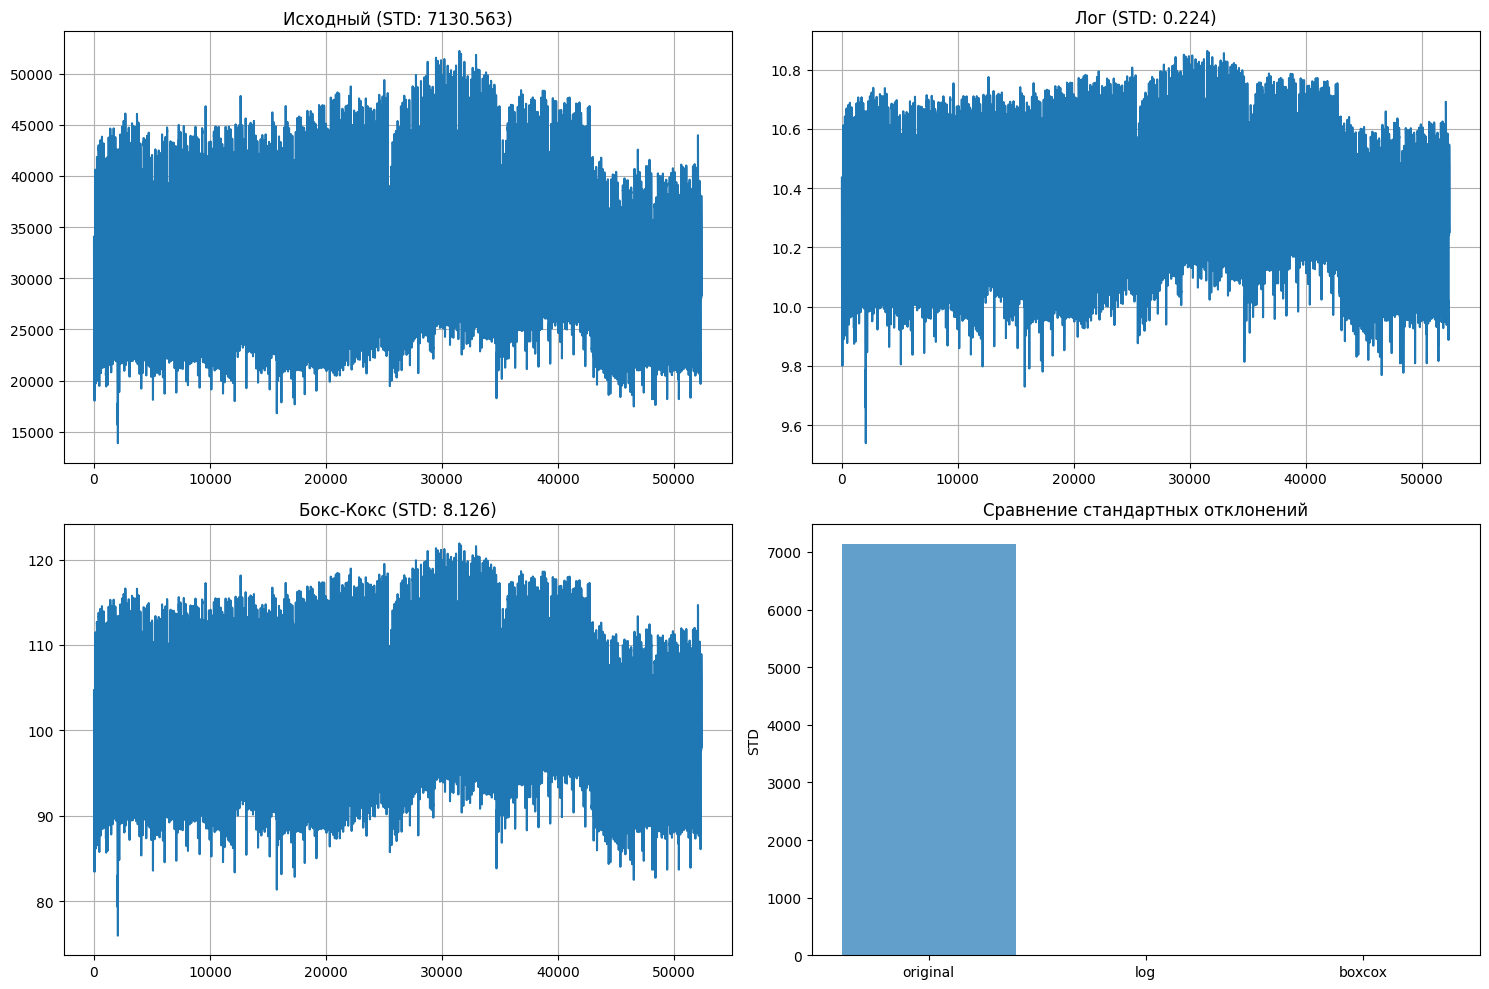


🎯 РЕКОМЕНДУЕМЫЙ МЕТОД: LOG

Итог:
Метод: log
Параметры: {}


In [46]:
def auto_select_transformation(series):
    """
    Автоматически выбирает лучший метод стабилизации дисперсии
    """
    # Проверяем возможность лог-трансформации
    can_use_log = series.min() > 0

    # Сравниваем методы
    methods, results = compare_variance_stabilization(series)

    # Выбираем метод с наибольшим улучшением STD
    best_method = 'original'
    best_improvement = 0

    for method, std, improvement, lmbda in results:
        if improvement > best_improvement:
            best_improvement = improvement
            best_method = method

    print(f"\n🎯 РЕКОМЕНДУЕМЫЙ МЕТОД: {best_method.upper()}")

    if best_method == 'original':
        return series, 'none', {}
    elif best_method == 'log':
        return methods['log'], 'log', {}
    elif best_method == 'boxcox':
        lmbda = [r[3] for r in results if r[0] == 'boxcox'][0]
        return methods['boxcox'], 'boxcox', {'lmbda': lmbda}

# Пример использования
print("АВТОМАТИЧЕСКИЙ ПОДБОР ПРЕОБРАЗОВАНИЯ:")
best_series, best_method, best_params = auto_select_transformation(series)

print(f"\nИтог:")
print(f"Метод: {best_method}")
print(f"Параметры: {best_params}")

1. СРАВНЕНИЕ МЕТОДОВ СТАБИЛИЗАЦИИ ДИСПЕРСИИ
✅ Автоподобранный параметр λ: 0.3468

📊 СРАВНЕНИЕ МЕТОДОВ СТАБИЛИЗАЦИИ ДИСПЕРСИИ:
Метод        STD        Улучшение    λ         
------------------------------------------------------------
original     7130.563   0.0        % -         
log          0.224      100.0      % -         
boxcox       8.126      99.9       % 0.3468    


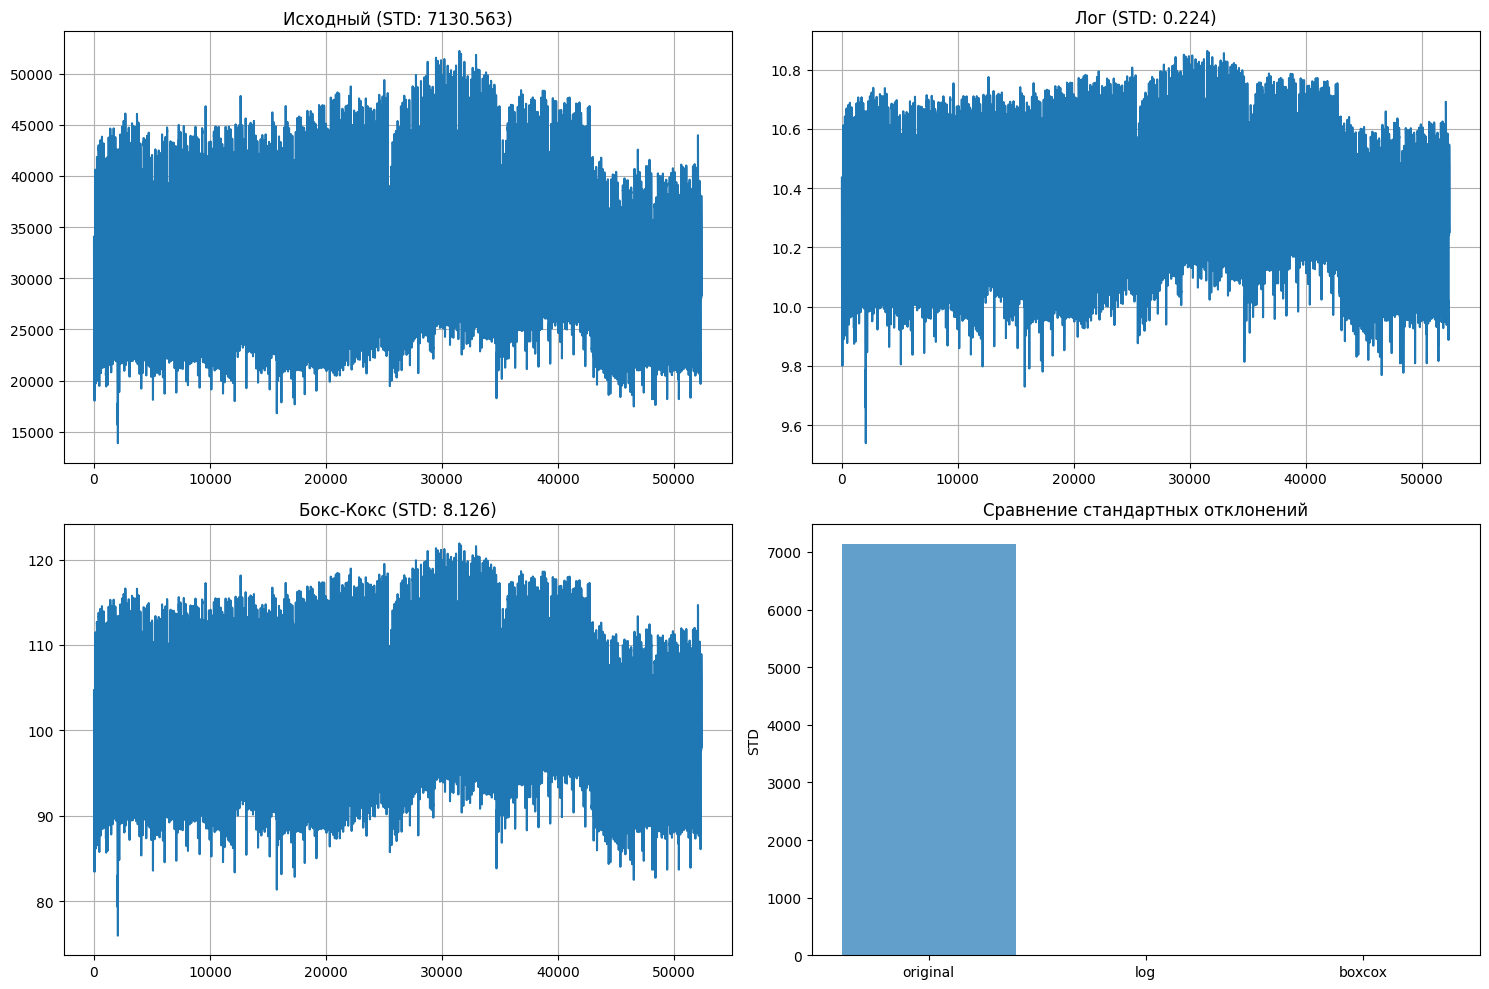


2. АВТОМАТИЧЕСКИЙ ВЫБОР МЕТОДА
✅ Автоподобранный параметр λ: 0.3468

📊 СРАВНЕНИЕ МЕТОДОВ СТАБИЛИЗАЦИИ ДИСПЕРСИИ:
Метод        STD        Улучшение    λ         
------------------------------------------------------------
original     7130.563   0.0        % -         
log          0.224      100.0      % -         
boxcox       8.126      99.9       % 0.3468    


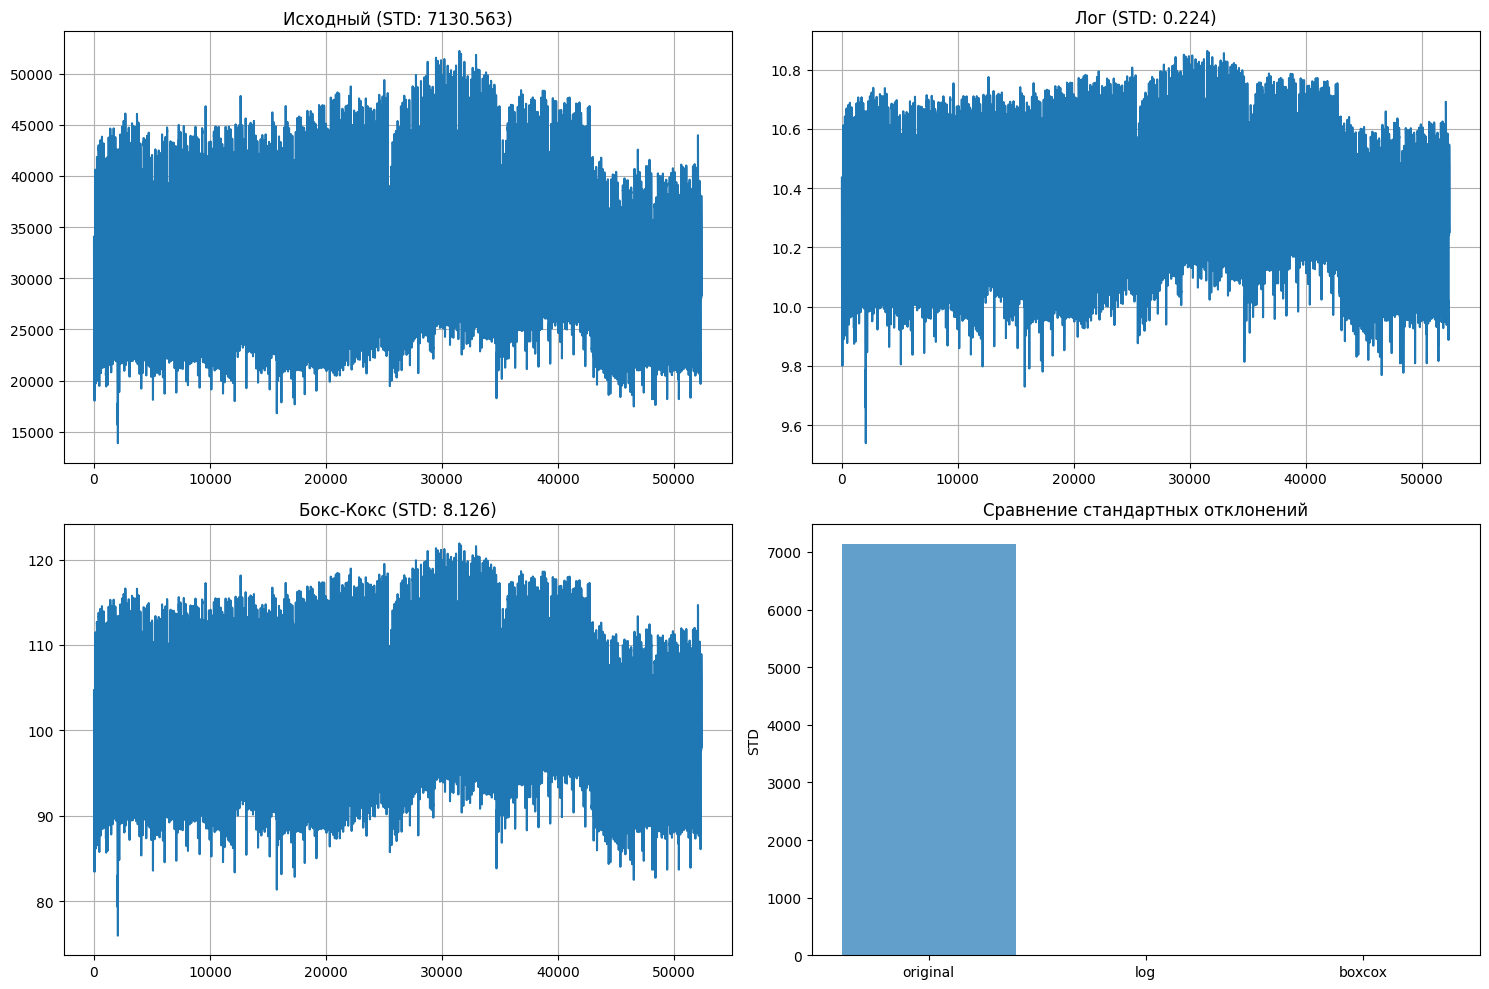


🎯 РЕКОМЕНДУЕМЫЙ МЕТОД: LOG

3. ПРИМЕНЕНИЕ ПОЛНОГО ПАЙПЛАЙНА С ВЫБРАННЫМ МЕТОДОМ
✅ Применено логарифмическое преобразование
✅ Применено сезонное дифференцирование (период=24)
✅ Применено дифференцирование 1-го порядка

4. ПРОВЕРКА СТАЦИОНАРНОСТИ

ТЕСТ СТАЦИОНАРНОСТИ: После полного пайплайна
ADF Statistic: -39.336737
p-value: 0.000000
Критические значения:
  1%: -3.430
  5%: -2.862
  10%: -2.567
✅ Ряд СТАЦИОНАРЕН (p-value ≤ 0.05)

5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТА


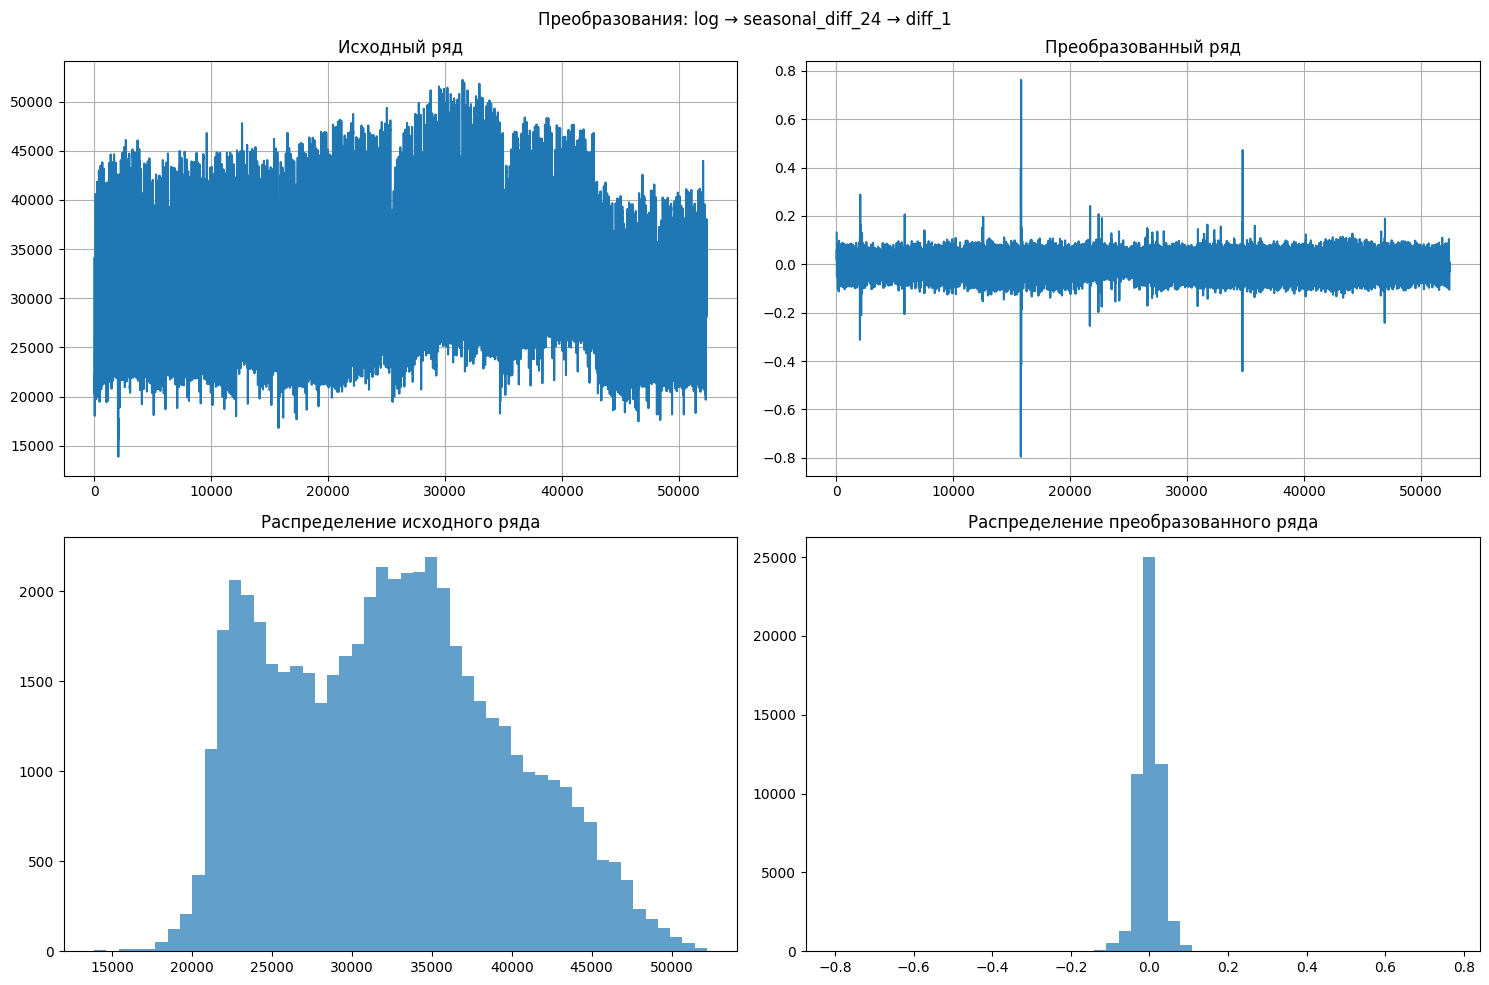


📊 Сравнение статистик:
Исходный ряд:      mean=32344.971, std=7130.563
Преобразованный ряд: mean=0.000, std=0.029

💾 ПАРАМЕТРЫ ДЛЯ ОБРАТНОГО ПРЕОБРАЗОВАНИЯ:
{'method': 'log', 'seasonal_period': 24, 'diff_order': 1}


In [47]:
series = df_with_features['PowerConsumption_Zone1']

print("1. СРАВНЕНИЕ МЕТОДОВ СТАБИЛИЗАЦИИ ДИСПЕРСИИ")
methods_comparison, results = compare_variance_stabilization(series)

print("\n2. АВТОМАТИЧЕСКИЙ ВЫБОР МЕТОДА")
best_series, best_method, best_params = auto_select_transformation(series)

print("\n3. ПРИМЕНЕНИЕ ПОЛНОГО ПАЙПЛАЙНА С ВЫБРАННЫМ МЕТОДОМ")
stationary_series, transformations, transform_params, original = make_stationary_pipeline_advanced(
    series,
    method=best_method,
    diff_order=1,
    seasonal_period=24
)

print("\n4. ПРОВЕРКА СТАЦИОНАРНОСТИ")
is_stationary = test_stationarity(stationary_series, "После полного пайплайна")

print("\n5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТА")
plot_transformations(original, stationary_series,
                    f"Преобразования: {' → '.join(transformations)}")

# Сохраняем параметры для обратного преобразования
print(f"\n💾 ПАРАМЕТРЫ ДЛЯ ОБРАТНОГО ПРЕОБРАЗОВАНИЯ:")
print(transform_params)

Этап 6. Модели экспоненциального сглаживания


Задача: Построить и сравнить классические модели.

📌 Что нужно сделать:
- SES (ExponentialSmoothing с trend=None, seasonal=None).
- Хольт (аддитивный): trend='add'.
- Хольт (мультипликативный): trend='mul' (только если данные > 0).
- Для каждой модели:
  - Включить optimized=True,
  - Построить прогноз на h шагов,
  - Рассчитать доверительные интервалы (если поддерживается),
  - Оценить качество на тестовой выборке.
  - Сравнить с наивным прогнозом (например, y[t+h] = y[t]).
- Провести диагностику адекватности:
  - Тест Льюнга–Бокса на остатки,
  - График остатков vs прогнозов (гомоскедастичность),
  - Q-Q plot и Shapiro–Wilk тест для нормальности.

🛠️ Инструменты: statsmodels.tsa.holtwinters.ExponentialSmoothing, scipy.stats.shapiro

📊 СРАВНЕНИЕ МОДЕЛЕЙ:
Naive        RMSE: 3271.895
SES          RMSE: 3271.895
Holt_Add     RMSE: 1455.479
Holt_Mul     RMSE: 1519.002

🔍 ДИАГНОСТИКА SES:
Ljung-Box p-value: 0.000
Shapiro-Wilk p-value: 0.000


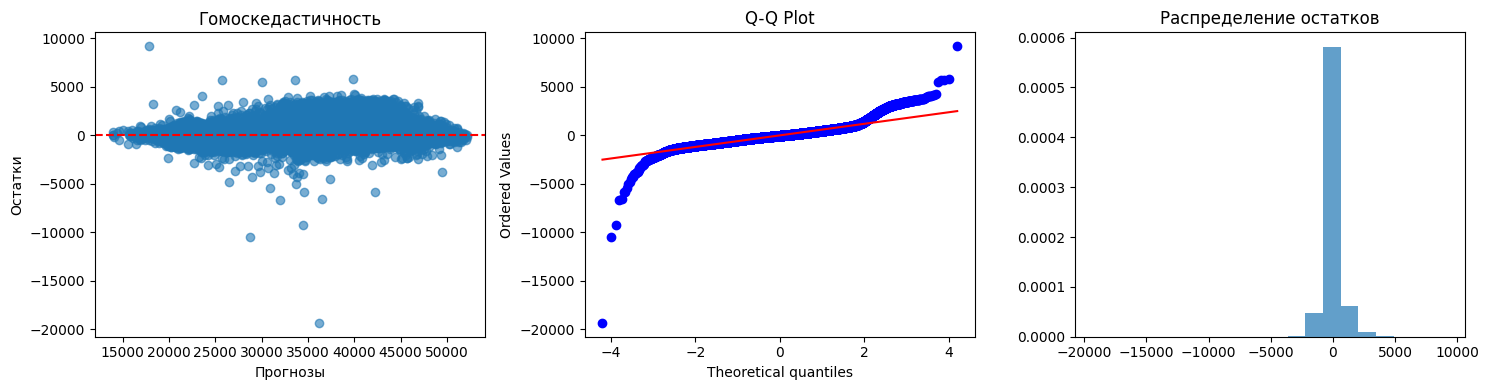


🔍 ДИАГНОСТИКА Holt_Add:
Ljung-Box p-value: 0.000
Shapiro-Wilk p-value: 0.000


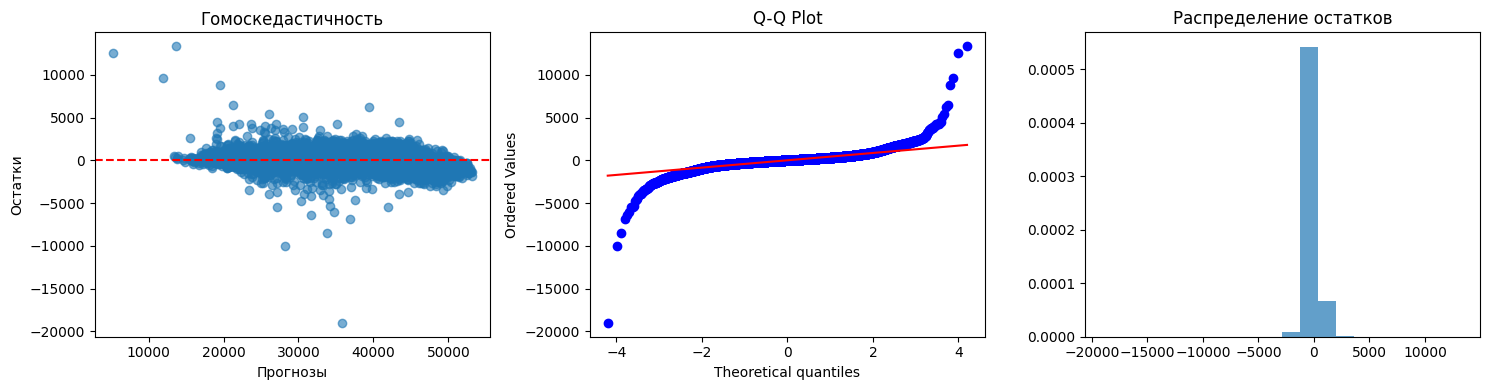


🔍 ДИАГНОСТИКА Holt_Mul:
Ljung-Box p-value: 0.000
Shapiro-Wilk p-value: 0.000


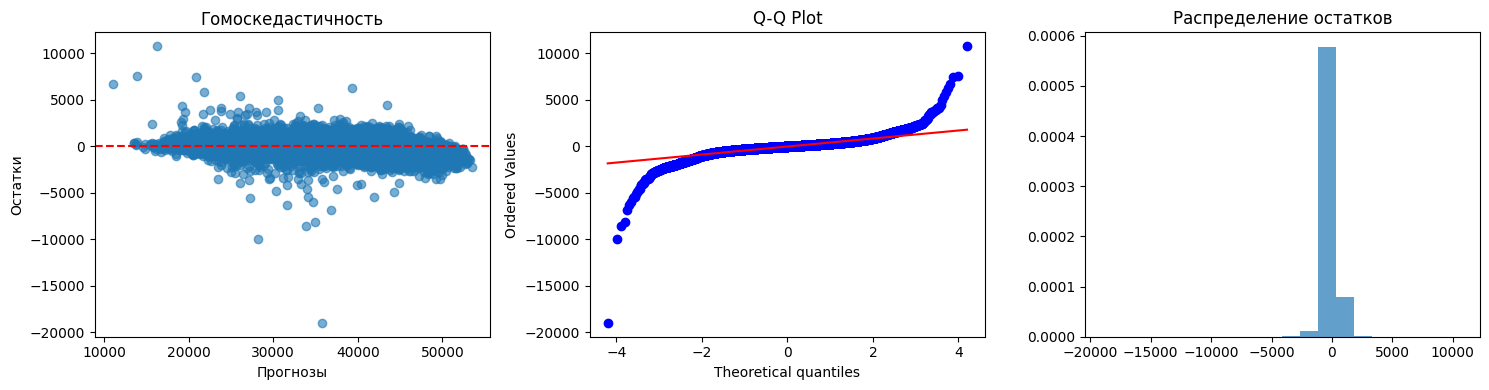

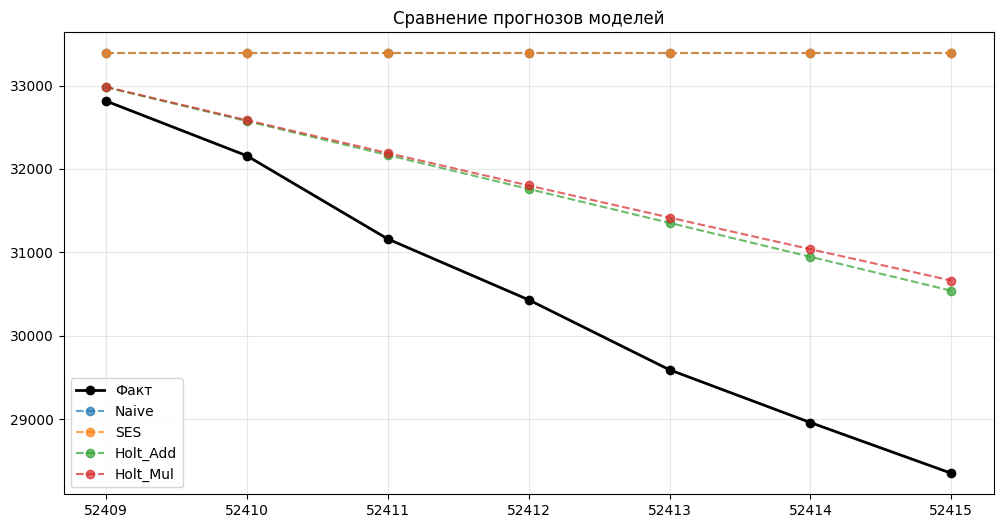

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

def build_ets_models(train, test, h=7):
    """Построение и сравнение моделей экспоненциального сглаживания"""
    models = {}

    # Наивный прогноз
    naive_pred = np.full(h, train.iloc[-1])
    models['Naive'] = {'pred': naive_pred}

    # SES
    ses_model = ExponentialSmoothing(train, trend=None, seasonal=None)
    ses_fit = ses_model.fit(optimized=True)
    models['SES'] = {'model': ses_fit, 'pred': ses_fit.forecast(h)}

    # Хольт аддитивный
    holt_add = ExponentialSmoothing(train, trend='add', seasonal=None)
    holt_add_fit = holt_add.fit(optimized=True)
    models['Holt_Add'] = {'model': holt_add_fit, 'pred': holt_add_fit.forecast(h)}

    # Хольт мультипликативный (только если данные > 0)
    if train.min() > 0:
        holt_mul = ExponentialSmoothing(train, trend='mul', seasonal=None)
        holt_mul_fit = holt_mul.fit(optimized=True)
        models['Holt_Mul'] = {'model': holt_mul_fit, 'pred': holt_mul_fit.forecast(h)}

    # Оценка качества
    print("📊 СРАВНЕНИЕ МОДЕЛЕЙ:")
    print("="*50)
    for name, result in models.items():
        if 'pred' in result:
            rmse = np.sqrt(np.mean((test.values - result['pred'])**2))
            print(f"{name:12} RMSE: {rmse:.3f}")

    return models

def model_diagnostics(model_fit, name):
    """Диагностика адекватности модели"""
    residuals = model_fit.resid.dropna()

    print(f"\n🔍 ДИАГНОСТИКА {name}:")

    # Тест Льюнга-Бокса
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"Ljung-Box p-value: {lb_test['lb_pvalue'].iloc[-1]:.3f}")

    # Тест Шапиро-Вилка
    shapiro_stat, shapiro_p = shapiro(residuals)
    print(f"Shapiro-Wilk p-value: {shapiro_p:.3f}")

    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Остатки vs прогнозы
    axes[0].scatter(model_fit.fittedvalues[10:], residuals[10:], alpha=0.6)
    axes[0].set_xlabel('Прогнозы')
    axes[0].set_ylabel('Остатки')
    axes[0].set_title('Гомоскедастичность')
    axes[0].axhline(y=0, color='r', linestyle='--')

    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot')

    # Распределение остатков
    axes[2].hist(residuals, bins=20, alpha=0.7, density=True)
    axes[2].set_title('Распределение остатков')

    plt.tight_layout()
    plt.show()


series = df_with_features['PowerConsumption_Zone1']
train, test = series[:-7], series[-7:]

# Построение моделей
models = build_ets_models(train, test, h=7)

# Диагностика для каждой модели
for name, result in models.items():
    if 'model' in result:
        model_diagnostics(result['model'], name)

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, 'ko-', label='Факт', linewidth=2)

for name, result in models.items():
    if 'pred' in result:
        plt.plot(test.index, result['pred'], 'o--', label=name, alpha=0.7)

plt.legend()
plt.title('Сравнение прогнозов моделей')
plt.grid(True, alpha=0.3)
plt.show()

In [49]:
from tabulate import tabulate

data = [
    ["Рекурсивный метод", 590.755, 657.7930361342621, 0.871],
    ["Прямой метод", 589.052, 655.8359763587429, 18.134],
    ["Гибридный метод", 589.052, 655.9511209756382, 23.289]
]

headers = ["Модель", "MAE", "RMSE", "Время, c"]
print(tabulate(data, headers=headers, tablefmt="grid"))

+-------------------+---------+---------+------------+
| Модель            |     MAE |    RMSE |   Время, c |
+===================+=========+=========+============+
| Рекурсивный метод | 590.755 | 657.793 |      0.871 |
+-------------------+---------+---------+------------+
| Прямой метод      | 589.052 | 655.836 |     18.134 |
+-------------------+---------+---------+------------+
| Гибридный метод   | 589.052 | 655.951 |     23.289 |
+-------------------+---------+---------+------------+
